# Install libraries

In [60]:
!pip install missingno
!pip install tune-sklearn
!pip install catboost
# !pip install scikit-optimize
# !pip install joblibspark
# !pip install pyspark

# Load libraries

In [61]:
import time
import numpy as np 
import numpy.ma as ma
import pandas as pd 
import datetime
import pickle
from tqdm import tqdm
import os
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
from random import sample, seed

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import six
import sys
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import StackingCVClassifier
from itertools import combinations
from hyperopt import fmin, space_eval, tpe, hp

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression,  RidgeClassifier, ElasticNet
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from scipy import stats
from scipy.stats import skew

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import rmse

from tune_sklearn import TuneSearchCV

from xgboost import XGBClassifier

from google.colab import drive
# Mount drive from Google
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Define functions

In [62]:
def get_all_combinations(L):
  """
  Get posslbe combinations of given models
  :param L: List containing all the names of the models

  :return combs
  """
  combs = []
  for n in range(0,len(L)+1):
      combs = combs + ([i for i in combinations(L,n)])

  return combs


# Get final prediction using the models trained

def ensemble_models_predict(df_x, weights):
  """
  Get the prediction using the stacking process
  :param df_x: Features
  :param weights: Best weights for the stacking process obtained with "get_best_weights" function

  :return best_weights and best_rmse
  """
  pred = ((weights[0] * stack_gen_model.predict(np.array(df_x)))
      + (weights[1] * cat_model_f.predict(df_x))
      + (weights[2] * lgbm_grid.best_estimator_.predict(df_x)) 
      + (weights[3] * xgb_grid.predict(df_x))
      + (weights[4] * gb_grid.predict(df_x))
      + (weights[5] * elasticnet_grid.best_estimator_.predict(df_x)) 
      + (weights[6] * lasso_grid.best_estimator_.predict(df_x))
      + (weights[7] * ridge_grid.best_estimator_.predict(df_x))
      + (weights[8] * svm_grid.predict(df_x))
      + (weights[9] * rf_grid.predict(df_x))
      # + (weights[10] * ann_grid.predict(df_x))
      # + (weights[10] * dt_grid.predict(df_x))

      )
  return pred

# Define function to calculate exploratory statistics (univariate)
def full_describe(dataframe,variables="all",variability=20,completeness=10): #summary, univariado, describe, analisis descriptivo, describir, analisis exploratorio
    #parameter description:
    #dataframe: Dataset to use in DataFrame format
    #variables: Variables to compute the univariate (EDA) analysis. Posible values: "all", input sequence (ie. "1:8"), 
    #input list of numbers or list of variable's names (ie. '1,4,9' o 'var1,var2,var3')
    #completeness: Minimum of accepted completeness per variable (value vetween 0 and 100)
    #variability: Minimum of accepted variability per variable (posible values: 0, 2, 10, 20, 50, 100)
    print("Describe process started, Time: "+ datetime.datetime.now().strftime("%H:%M:%S"))
    start1 = datetime.datetime.now()
    if variables == "all": #If you wish to analyze all the variables
        #Apply "describe" function and add  adicionar (concatenated) rows with Missing values
        resumen=pd.concat([dataframe.describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.isnull().sum().to_frame(name = 'missing').T],sort=False)
    elif ":" in variables: #If you wish to analyze the sequence of variables n1:n2
        #Apply "describe" function and add  adicionar (concatenated) rows with Missing values
        variables_serie=list(pd.to_numeric((variables).split(':')))
        variables_serie=list(pd.Series(range(variables_serie[0],variables_serie[1])))
        resumen=pd.concat([dataframe.iloc[:,variables_serie].describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.iloc[:,variables_serie].isnull().sum().to_frame(name = 'missing').T],sort=False)
    else:
        try: #If you wish to analyze variables of numericala array (positions)[n1,n2,n3,...]
            # Split variable by comma
            variables_serie=list(pd.to_numeric((variables).split(',')))
            #Apply "describe" function and add  adicionar (concatenated) rows with Missing values
            resumen=pd.concat([dataframe.iloc[:,variables_serie].describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.iloc[:,variables_serie].isnull().sum().to_frame(name = 'missing').T],sort=False)
        except: 
            if set(list(variables.split(","))).issubset(list(dataframe.columns)): #If you wish to analyze variables using array string (field names) ['nom1','nom2','nom3',...]
                # Split variable by comma, creating a string list
                variables_serie=list(variables.split(","))
                #Apply "describe" function and add  adicionar (concatenated) rows with Missing values
                resumen=pd.concat([dataframe.loc[:,variables_serie].describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.loc[:,variables_serie].isnull().sum().to_frame(name = 'missing').T],sort=False)
            else: #Garbage Collector for different cases
                resumen="Invalid entry for variables"
                
    print("Describe function calculatation finished. Elapsed Time: "+str((datetime.datetime.now() - start1).seconds)+" segs")
    
    start2 = datetime.datetime.now()
    print("Inicia calculo de completeness and variability, Time: "+ datetime.datetime.now().strftime("%H:%M:%S"))
    if isinstance(resumen, pd.DataFrame)==True: #Verify if there is any error in the imputed parameters 
        #Calculate total count of records
        resumen.loc['total count']=resumen.loc[['count','missing']].sum()
        #Calculate percentage os Missing values
        resumen.loc['% missing']=np.around((resumen.loc['missing']*100/resumen.loc['total count']).astype(np.double),4)
        #Transpose to use better the code
        resumen=resumen.T
        #Calculate variability
        resumen['variability'] = np.where(resumen['min']==resumen['max'], '00_variation', 
                                           np.where(resumen['1%']==resumen['99%'], '02_variation', 
                                                   np.where(resumen['5%']==resumen['95%'], '10_variation', 
                                                           np.where(resumen['10%']==resumen['90%'], '20_variation', 
                                                                   np.where(resumen['25%']==resumen['75%'], '50_variation', 
                                                                           'high_variation')))))
        if variability == 0:
            resumen['variability_decision'] = "accept"
        elif variability == 2:
            resumen['variability_decision'] = np.where(resumen['variability']=='00_variation', 'reject',
                                                        'accept')
        elif variability == 10:
            resumen['variability_decision'] = np.where((resumen['variability']=='00_variation') | (resumen['variability']=='02_variation'), 'reject',
                                                        'accept')
        elif variability == 20:
            resumen['variability_decision'] = np.where((resumen['variability']=='00_variation') | (resumen['variability']=='02_variation') | (resumen['variability']=='10_variation'), 'reject',
                                                        'accept')
        elif variability == 50:
            resumen['variability_decision'] = np.where((resumen['variability']=='00_variation') | (resumen['variability']=='02_variation') | (resumen['variability']=='10_variation') | (resumen['variability']=='20_variation'), 'reject',
                                                        'accept')
        elif variability == 100: 
            resumen['variability_decision'] = np.where((resumen['variability']=='00_variation') | (resumen['variability']=='02_variation') | (resumen['variability']=='10_variation') | (resumen['variability']=='20_variation') | (resumen['variability']=='50_variation'), 'reject',
                                                        'accept')
        else:
            resumen['variability_decision']="VALOR NO VALIDO"
            print("Invalid entry for parameter variability")
        #Calcular completeness
        resumen['completeness_decision']=np.where(resumen['% missing']==0,'accept_100',
                                                 np.where(resumen['% missing']>completeness, 'reject','accept')) 
    else:
        resumen="Invalid entry for variables"
        
    print("Completeness and variability calculation finished. Elapsed time: "+str((datetime.datetime.now() - start2).seconds)+" segs")
    
    
    print("Whole process completed. Total Elapsed time: "+str((datetime.datetime.now() - start1).seconds)+" segs")
    return resumen

# Define parameters

In [63]:
# Define paths
root_path = '/content/gdrive/MyDrive/Kaggle_competitions/Titanic - Machine Learning from Disaster'
output_path = root_path + '/output'
submissions_path = root_path + '/submissions'
models_path = root_path + '/models'

# Define random state for reproducibility
random_state = 0

# Load data from Kaggle

In [64]:
# Install kaggle
!pip -q install kaggle

# Upload the JSON file downloaded from kaggle (API token).
os.environ['KAGGLE_CONFIG_DIR'] = root_path + "/Kaggle"

kaggle_path = "'" + root_path +"/Kaggle'"
%cd $kaggle_path

# Download the dataset in zip format
!kaggle competitions download -c titanic

# # List all the datasets available in Kaggle
# # !kaggle datasets list

# #Decompress the data
# # !unzip -o -q scene-classification.zip

/content/gdrive/MyDrive/Kaggle_competitions/Titanic - Machine Learning from Disaster/Kaggle
train.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


# Load data

In [65]:
train = pd.read_csv("train.csv", sep=",")
test = pd.read_csv("test.csv", sep=",")

# Exploratory Data Analysis (EDA)

## Review Response Variable

In [66]:
# Check missing values
print(train[["Survived"]].isna().sum())

Survived    0
dtype: int64


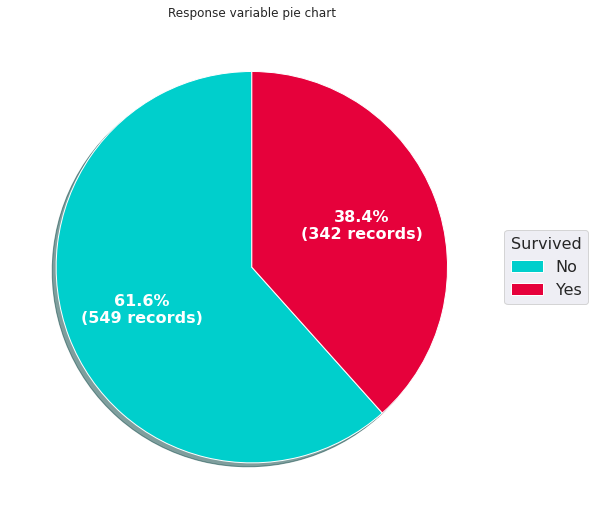

In [67]:
# Creating dataset
legend = ['No', 'Yes']
 
data = np.ravel(train['Survived'].value_counts()[0:2])

 
# Creating explode data
explode = (0.0, 0.0)
 
# Creating color parameters
colors = ( "#00cfcc", "#e6013b")

# Wedge properties
wp = { 'linewidth' : 1}
 
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} records)".format(pct, absolute)
 
# Creating plot
fig, ax = plt.subplots(figsize =(9, 9))
wedges, texts, autotexts = ax.pie(data,
                                  autopct = lambda pct: func(pct, data),
                                  explode = explode,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="white"))
 
# Adding legend
ax.legend(wedges, legend,
          title ="Survived",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1), prop={'size': 16},title_fontsize=16)


plt.setp(autotexts, size = 16, weight ="bold")
ax.set_title("Response variable pie chart")
 
# show plot
plt.show()



## Pre-process to leave all the explanatory variables in one data set


In [68]:
# Eliminate ID
# train.drop(['PassengerId', 'Name','Ticket'], axis=1, inplace=True)
# test.drop(['PassengerId', 'Name','Ticket'], axis=1, inplace=True)

# Leave test and train features in one dataframe
train_features = train.drop(['Survived'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)
y = train['Survived'].reset_index(drop=True)

## Review Explanatory variables

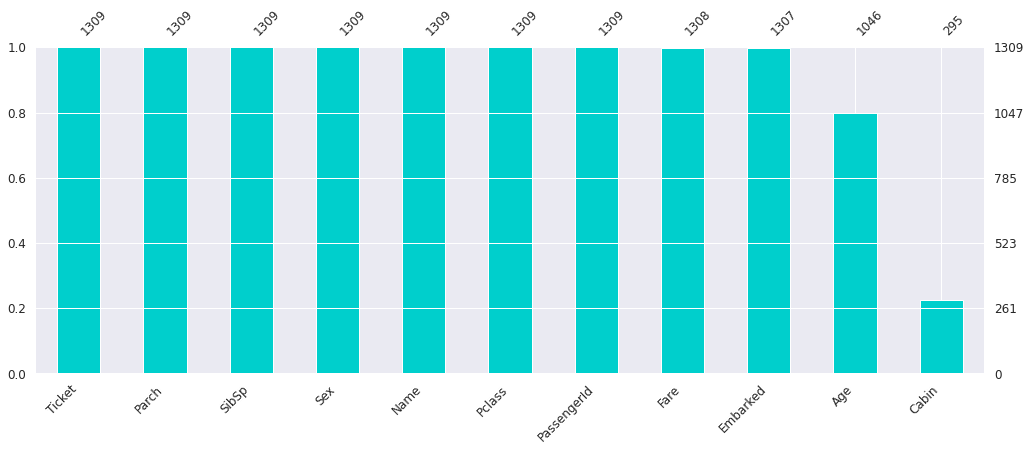

In [69]:
# Bar plot of missing values and percentage
msno.bar(features, labels=True, figsize=(17,6), fontsize=12, sort="descending", color="#00cfcc")

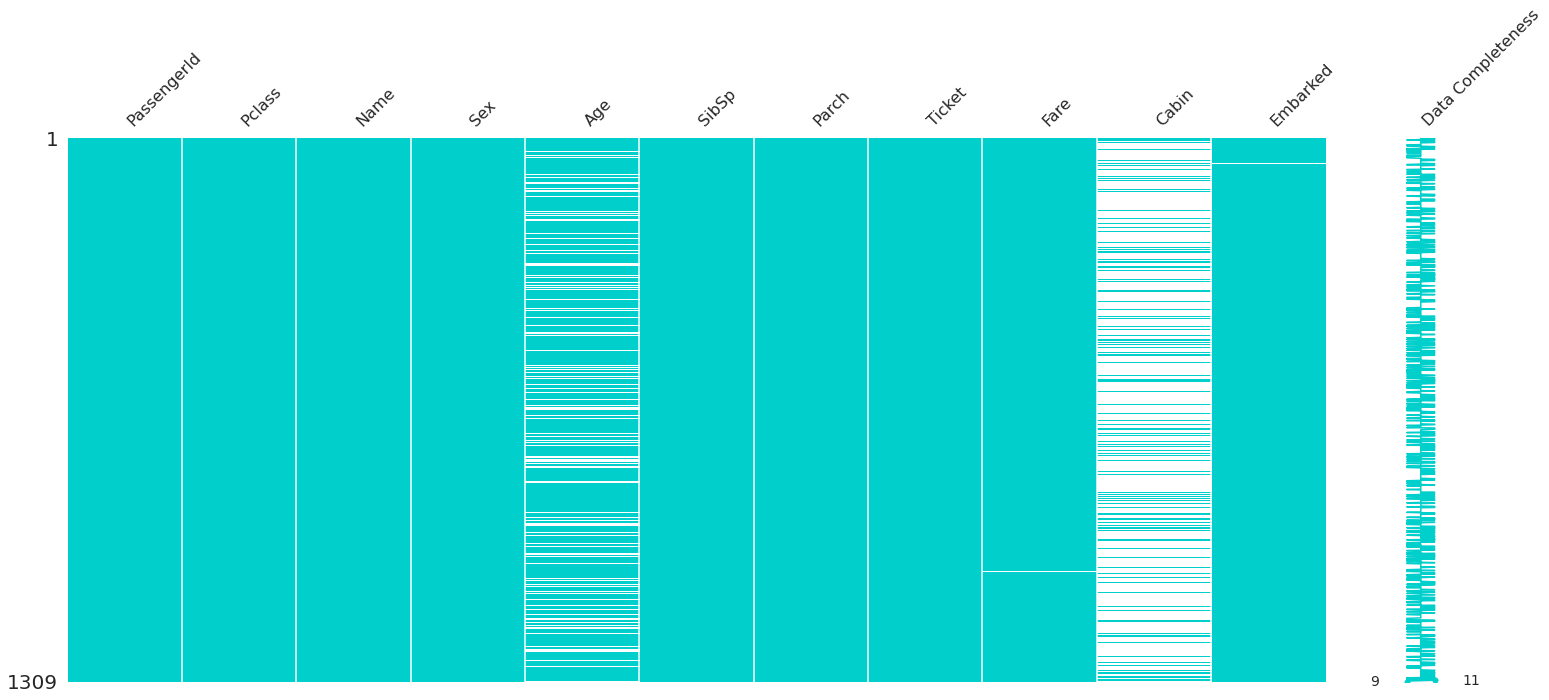

In [70]:
# Matrix showing the pisitions of the missing values for each variable
msno.matrix(features, labels=True, color = (0/255,207/255,204/255))

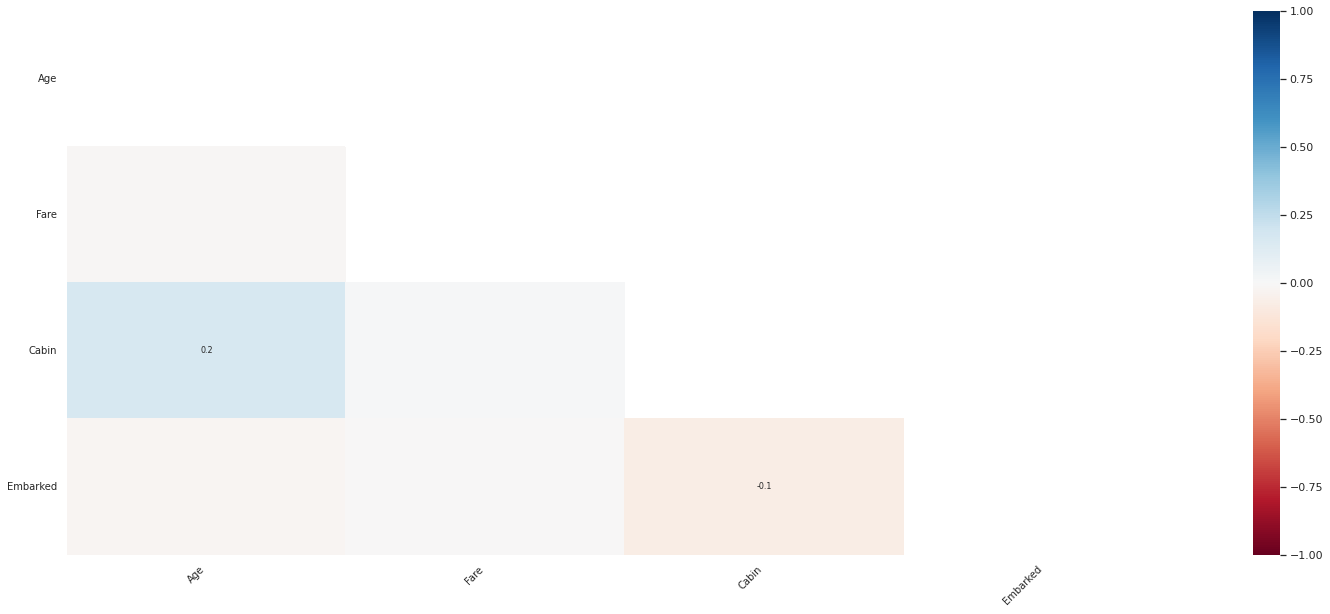

In [71]:
# Heat map showing correlation among variables
msno.heatmap(features, figsize=(25,10), fontsize=10)

In [72]:
# Execute univariate analysis (mainly or quantivative variables)
our_summary = full_describe(dataframe = features , variability = 20 , completeness = 10)

Describe process started, Time: 12:30:10
Describe function calculatation finished. Elapsed Time: 0 segs
Inicia calculo de completeness and variability, Time: 12:30:10
Completeness and variability calculation finished. Elapsed time: 0 segs
Whole process completed. Total Elapsed time: 0 segs


In [73]:
# Export summary to excel fileon the actual local machine to review
our_summary.to_excel(output_path + '/resumen_variables.xlsx', sheet_name = 'resumen')
# files.download("resumen_variables.xlsx")

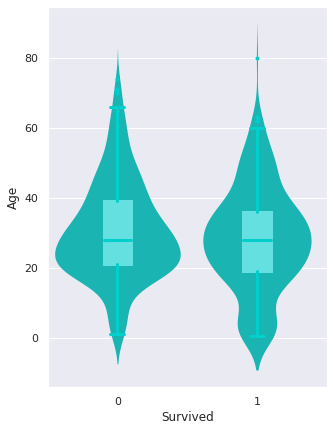

In [74]:
# Violin plot for Age
sns.set(style="darkgrid", rc = {'figure.figsize':(5,7)})

ax = sns.violinplot(data=train, x = 'Survived', y='Age', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=train, x = 'Survived', y='Age', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()

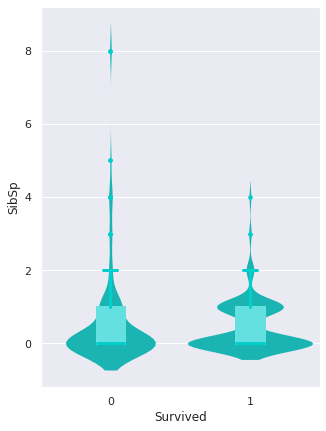

In [75]:
# Violin plot for SibSp
sns.set(style="darkgrid", rc = {'figure.figsize':(5,7)})

ax = sns.violinplot(data=train, x = 'Survived', y='SibSp', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=train, x = 'Survived', y='SibSp', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()

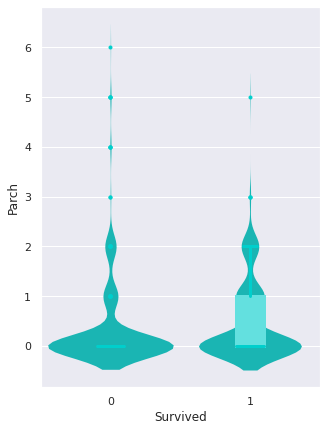

In [76]:
# Violin plot for Parch
sns.set(style="darkgrid", rc = {'figure.figsize':(5,7)})

ax = sns.violinplot(data=train, x = 'Survived', y='Parch', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=train, x = 'Survived', y='Parch', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()

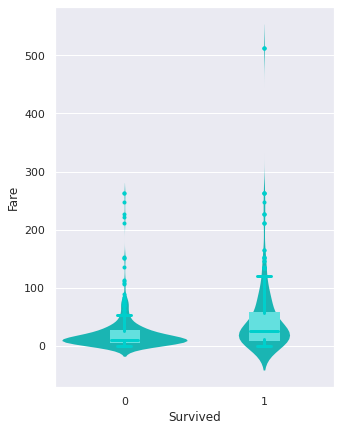

In [77]:
# Violin plot for Fare
sns.set(style="darkgrid", rc = {'figure.figsize':(5,7)})

ax = sns.violinplot(data=train, x = 'Survived', y='Fare', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=train, x = 'Survived', y='Fare', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()

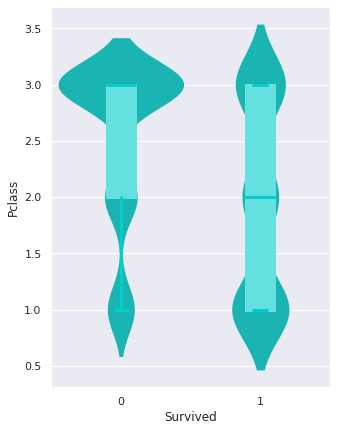

In [78]:
# Violin plot for Fare
sns.set(style="darkgrid", rc = {'figure.figsize':(5,7)})

ax = sns.violinplot(data=train, x = 'Survived', y='Pclass', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=train, x = 'Survived', y='Pclass', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()

In [79]:
# Remove features that are not useful (a lot of missing):
# features = features.drop(['Cabin'], axis=1)

In [80]:
# Since these column are actually a category , using a numerical number will lead the model to assume
# that it is numerical , so we convert to string .
# features['MSSubClass'] = features['MSSubClass'].apply(str)
# features['YrSold'] = features['YrSold'].astype(str)
# features['MoSold'] = features['MoSold'].astype(str)

In [81]:
# Fill missing value with 0 for continuos variables
# numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# numerics = []
# for i in features.columns:
#     if features[i].dtype in numeric_dtypes:
#         numerics.append(i)
# features.update(features[numerics].fillna(0))

In [82]:
# Fill missing with mode for categorical variables 
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
# features.update(features[objects].fillna(features.mode().iloc[0]))

# Feature Engineering

In [83]:
# Fare
train['Embarked'] = train['Embarked'].fillna(train.Embarked.mode().item())
test['Fare'] = test['Fare'].fillna(train.Fare.mean())

train['Words_Count'] = train['Name'].apply(lambda x: len(x.split()))
test['Words_Count'] = test['Name'].apply(lambda x: len(x.split()))

# WikiId
# train = train.drop(index=train[train['WikiId'].isnull()].index).reset_index(drop=True)

# Age_wiki
# train['Age_wiki'] = train.groupby(['Class', 'Sex']).Age_wiki.apply(lambda x: x.fillna(x.median()))

In [84]:
# Combine train and test sets for preprocessing
train_test = pd.concat([train, test], axis=0)

# Destination
# train_test['Destination'] = train_test['Destination'].replace({'Brighton, Boston, Massachusetts, US': 'Boston, Massachusetts, US'})
# destin = train_test['Destination'].str.split(',', expand=True).rename(columns={0:'Destination_City', 1: 'Destination_State', 2: 'Destination_Country'})
# train_test = pd.concat([train_test, destin], axis=1)

# Hometown
# hometo = train_test['Hometown'].str.split(',', expand=True).rename(columns={0: 'Home_City', 1: 'Home_County', 2:'Home_Country'}).drop(columns=3)
# train_test = pd.concat([train_test, hometo], axis=1)

# Returning
# train_test['Returning'] = (train_test.Home_Country==train_test.Destination_Country)

# FamilySize
train_test['FamilySize'] = train_test['SibSp'] + train_test['Parch'] + 1

# IsAlone
train_test['IsAlone'] = train_test['FamilySize'] <= 1

# Cabin/Deck
cabin_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 1, 'M': 8}
train_test['Deck'] = train_test['Cabin'].str[0].fillna('M').replace(cabin_map)

# Fill Null values
train_test = train_test.fillna('None')

# Name
train_test['FamilyName'] = train_test.Name.str.split(',', -1, expand=True)[0]
train_test['Honorific'] = train_test.Name.str.split(',', -1, expand=True)[1].str.split('.', 1, expand=True)[0].str.strip().replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Lady': 'Rare', 'Don': 'Rare', 'Jonkheer': 'Rare', 'the Countess': 'Rare', 'Sir': 'Rare', 'Mme': 'Rare', 'Capt': 'Mr', 'Major': 'Mr', 'Col': 'Mr', 'Rev': 'Mr', 'Dr': 'Mr'})
train_test['FullName'] = train_test.Name.str.split(',', -1, expand=True)[1].str.split('.', 1, expand=True)[1].str.strip()
train_test['FirstName'] = train_test.FullName.str.split(' ', 1, expand=True)[0].str.strip('(').str.strip(')')
train_test['NameLength'] = train_test.FullName.apply(lambda x: len(x))
train_test = train_test.drop(columns=['Pclass', 'Cabin', 'Name', 'FullName', 'PassengerId', 'Ticket'])

# Label Encode
for column in train_test.dtypes[(train_test.dtypes==object) | (train_test.dtypes==bool)].index:
    train_test[column] = pd.Categorical(train_test[column]).codes

# One Hot encode
cat_features = train_test.columns[~train_test.columns.isin(['Words_Count','Survived', 'Fare', 'Age_wiki', 'FamilySize', 'FullName', 'NameLength'])]
train_test = pd.get_dummies(train_test, columns=cat_features)

# Splitting into train and test
train = train_test.iloc[train.index]
test = train_test.iloc[test.index+train.shape[0]].drop(columns=['Survived'])

# Resetting index in case
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print('Train new shape:', train.shape)
print('Test new shape:', test.shape)

Train new shape: (891, 1551)
Test new shape: (418, 1550)


In [85]:
''' Calculating correlation of all the categorical Variables against the ['SalePrice'] one at the time '''

# List with all categoricals Variables
lista_variables = objects

df_X = []
corr_vars_cat = pd.DataFrame(columns=['variable','fvalue','pvalue','-log_pvalue'])
# we iterate over each variable
for variable in tqdm(lista_variables):
    # We need to clear the list for each iteration.
    df_X.clear()   
    # then, for each variable, we iterate over each one of its category
    for categoria in list(set(features[variable].values)):
        res = pd.concat([features, y],axis=1).loc[features[variable] == categoria]['Survived']
        df_X.append(res)

    fvalue, pvalue = stats.kruskal(*df_X, nan_policy = 'omit')
    
    row_to_append = pd.DataFrame({'variable': [variable], 'fvalue': [fvalue], 'pvalue': [pvalue], '-log_pvalue': [-np.log(pvalue)]})
    corr_vars_cat = pd.concat([corr_vars_cat, row_to_append], axis=0)
    # print("===============================================================================================================")
    # print("test: F-value",fvalue,"P-value", pvalue,"-log(P-value)",-np.log(pvalue))
    #print("VAR:{0:s} CAT:{1:s} F-VAL:{2:10.6f} PVAL:{3:10.6f} LOG:{4:10.6f}".format(variable, categoria, fvalue, pvalue, -np.log(pvalue)))


corr_vars_cat.sort_values('-log_pvalue', ascending = False)

100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


,variable,fvalue,pvalue,-log_pvalue
0,Sex,262.755343,4.304563e-59,134.392845
0,Ticket,765.709355,9.999679e-01,0.000032
0,Name,890.000000,1.000000e+00,-0.000000
0,Cabin,NaN,NaN,NaN
0,Embarked,NaN,NaN,NaN


In [86]:
# Reviewing the categories of categorical variables
var_desired = 'Sex'
print(features[var_desired].value_counts())
features.columns[features.columns.str.contains(var_desired)]

male      843
female    466
Name: Sex, dtype: int64


Index(['Sex'], dtype='object')

In [87]:
# Create dummie variables and stack them with the whole dataframe
# final_features = pd.get_dummies(features).reset_index(drop=True)
# final_features.shape

In [88]:
# # Find highly skewed features
# numeric_features = final_features.dtypes[final_features.dtypes != object].index
# skewed_features = final_features[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
# high_skew = skewed_features[skewed_features > 0.5]
# skew_index = high_skew.index

# # Normalize skewed features using log_transformation
# for i in skew_index:
#     final_features[i] = np.log1p(final_features[i])

In [89]:
# Divide features of train and test
# X = final_features.iloc[:len(y), :]
X = train.drop(columns='Survived', axis=1)
X_sub = test
X.shape, y.shape, X_sub.shape

((891, 1550), (891,), (418, 1550))

In [90]:
# Calculate correlation matrix to check correlation with the response variable Survived
corr_matrix = pd.concat([X,y],axis=1).corr()
corr_matrix = corr_matrix[['Survived']].sort_values('Survived',ascending=False)
# Export summary to excel file on the actual local machine to review
corr_matrix.to_excel(output_path + '/correlation.xlsx', sheet_name = 'correlation')
# files.download("correlation.xlsx")

# Modelling

# Get train, validation and test data

In [91]:
# Divide data in train and an auxiliar for validation/test randomly, taking the train size as 60% of the whole data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = random_state)

# Divide auxiliar data in valdiation/train randomly, taking the validation and train size as 15% (for each) of the whole data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = random_state)

# X = x_train
# y = y_train

print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

# Define parameters for fine tuning

num_folds = 5

kf = KFold(n_splits=num_folds, random_state=random_state, shuffle=True)

# Create dataframes to store models calculated to apply ensemble method
df_train_ens = pd.DataFrame()
df_test_ens = pd.DataFrame()
df_val_ens = pd.DataFrame()
df_eva_ens = pd.DataFrame()

X Train shape: (534, 1550)
Y Train shape: (534,)
X Validation shape: (178, 1550)
Y Validation shape: (178,)
X Test shape: (179, 1550)
Y Test shape: (179,)


## Applying XG-Boost technique

In [92]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/XGboost_model.pkl','rb')
  xgb_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_XGboost.pkl','rb')
  best_params = pickle.load(infile)
else:
  # Define function to minimize
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      
      # Use params to create new model
      model = make_pipeline( XGBClassifier(random_state = random_state, **params))

      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Define grid (space)
  parameters = {'max_depth': hp.choice('max_depth', range(0,5)), 
              'n_estimators': hp.choice('n_estimators', range(0,10)), 
              'max_features': hp.choice('max_features', ['sqrt', 'auto']), 
              'warm_start': hp.choice('warm_start', [True])}

  # Minimize function
  best = fmin(fn = param_selection_cv 
            , space = parameters 
            , algo = tpe.suggest 
            , max_evals = 10
            , rstate = np.random.RandomState(random_state)
          )
  
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)

  # Define model with best hyperparameters
  xgb_grid = make_pipeline( XGBClassifier(random_state = random_state, **best_params))

  # Train Model
  xgb_grid.fit(x_train,y_train)
  
  #Save model
  with open(models_path + '/XGboost_model.pkl', 'wb') as pickfile:
     pickle.dump(xgb_grid, pickfile)
  with open(models_path + '/best_params_XGboost.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)
print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")

# predicted_prob_val = xgb_grid.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

# predicted_prob_train = xgb_grid.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = xgb_grid.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = xgb_grid.predict(x_train)

# Predict values of regression with validation
ypred_val = xgb_grid.predict(x_val)

# Predict values of regression with test
ypred_test = xgb_grid.predict(x_test)

print("Evaluating results of the classification:")
print("Accuracy Score for train, validation, test: {}, {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val), accuracy_score(y_test, ypred_test)))
print("Precision Score for train, validation, test: {}, {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val), precision_score(y_test, ypred_test)))
print("Recall Score for train, validation, test: {}, {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val), recall_score(y_test, ypred_test)))
print("F1 Score for train, validation, test: {}, {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val), f1_score(y_test, ypred_test)))
# print("AUROC for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val), roc_auc_score(y_test, predicted_prob_test)))
# print("GINI for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1, roc_auc_score(y_test, predicted_prob_test) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(xgb_grid, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (534, 1550)
Y Train shape: (534,)
X Validation shape: (178, 1550)
Y Validation shape: (178,)
X Test shape: (179, 1550)
Y Test shape: (179,)
Best parameters found: 
{'max_depth': 2, 'max_features': 'auto', 'n_estimators': 2, 'warm_start': True}
Evaluating results of the classification:
Accuracy Score for train, validation, test: 0.8426966292134831, 0.8314606741573034, 0.7821229050279329
Precision Score for train, validation, test: 0.8210526315789474, 0.8142857142857143, 0.6949152542372882
Recall Score for train, validation, test: 0.7572815533980582, 0.7702702702702703, 0.6612903225806451
F1 Score for train, validation, test: 0.7878787878787878, 0.7916666666666666, 0.6776859504132231
Feature importance:
Ejecución: 0.27501773834228516 seconds


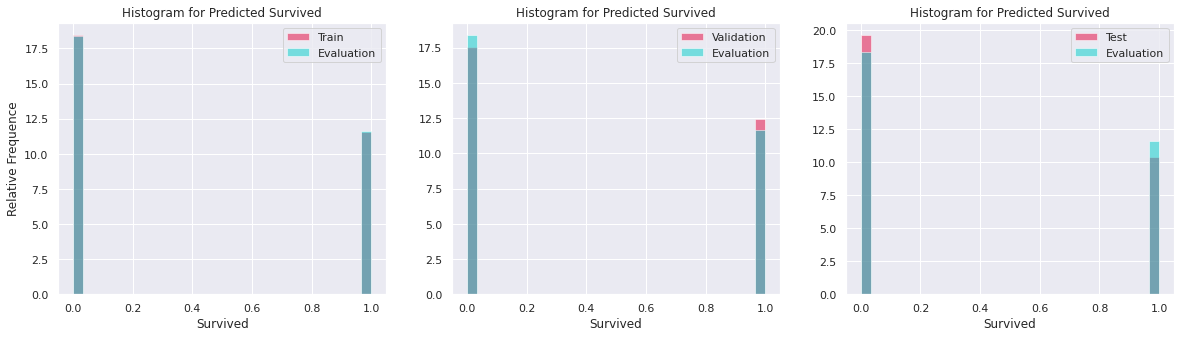

In [93]:
#  Load test data
df_evaluation = pd.read_csv("gender_submission.csv", sep=",")

# Make prediction over evaluation data
# predicted_prob_eva = xgb_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
df_evaluation.iloc[:,1] = xgb_grid.predict(X_sub)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 3)
plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.show()

# Export file to submit in competition
df_evaluation.to_csv(submissions_path + '/Titanic_XGBOOST_Jimenez_v1.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'xgb'
df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation.Survived], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Random Forest technique

In [94]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/RandomForest_model.pkl','rb')
  rf_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_RandomForest.pkl','rb')
  best_params = pickle.load(infile)  
else:
  # Define function to minimize
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      
      # Use params to create new model
      model = make_pipeline( RandomForestClassifier(random_state = random_state, **params))
      
      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Define grid (space)
  parameters = {'n_estimators': hp.choice('n_estimators', [100])
        , 'max_depth': hp.choice('max_depth', range(3,20,2))
        # , 'min_samples_split' : hp.choice('min_samples_split', range(1,10,1)) 
        # , 'max_features' : hp.choice('max_features', range(1,10,1)) 
        , 'bootstrap' : hp.choice('bootstrap', [True, False]) 
        
        # , 'min_samples_leaf' : hp.choice('min_samples_leaf', range(1,20,1))
    }

  # Minimize function
  best = fmin(fn = param_selection_cv 
            , space = parameters 
            , algo = tpe.suggest 
            , max_evals = 10
            , rstate = np.random.RandomState(random_state)
          )
  
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)

  # Define model with best hyperparameters
  rf_grid = make_pipeline( RandomForestClassifier(random_state = random_state, **best_params))

  # Fit the model
  rf_grid.fit(x_train, y_train)

  #Save model
  with open(models_path + '/RandomForest_model.pkl', 'wb') as pickfile:
     pickle.dump(rf_grid, pickfile)
  with open(models_path + '/best_params_RandomForest.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)
print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")

# predicted_prob_val = rf_grid.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

# predicted_prob_train = rf_grid.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# predicted_prob_val = rf_grid.predict_proba(x_val)[:, 1]
# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = rf_grid.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = xgb_grid.predict(x_train)

# Predict values of regression with validation
ypred_val = xgb_grid.predict(x_val)

# Predict values of regression with test
ypred_test = xgb_grid.predict(x_test)
print("Evaluating results of the classification:")
print("Accuracy Score for train, validation, test: {}, {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val), accuracy_score(y_test, ypred_test)))
print("Precision Score for train, validation, test: {}, {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val), precision_score(y_test, ypred_test)))
print("Recall Score for train, validation, test: {}, {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val), recall_score(y_test, ypred_test)))
print("F1 Score for train, validation, test: {}, {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val), f1_score(y_test, ypred_test)))
# print("AUROC for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val), roc_auc_score(y_test, predicted_prob_test)))
# print("GINI for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1, roc_auc_score(y_test, predicted_prob_test) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(rf_grid, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (534, 1550)
Y Train shape: (534,)
X Validation shape: (178, 1550)
Y Validation shape: (178,)
X Test shape: (179, 1550)
Y Test shape: (179,)
Best parameters found: 
{'bootstrap': False, 'max_depth': 11, 'n_estimators': 100}
Evaluating results of the classification:
Accuracy Score for train, validation, test: 0.8426966292134831, 0.8314606741573034, 0.7821229050279329
Precision Score for train, validation, test: 0.8210526315789474, 0.8142857142857143, 0.6949152542372882
Recall Score for train, validation, test: 0.7572815533980582, 0.7702702702702703, 0.6612903225806451
F1 Score for train, validation, test: 0.7878787878787878, 0.7916666666666666, 0.6776859504132231
Feature importance:
Ejecución: 0.23432207107543945 seconds


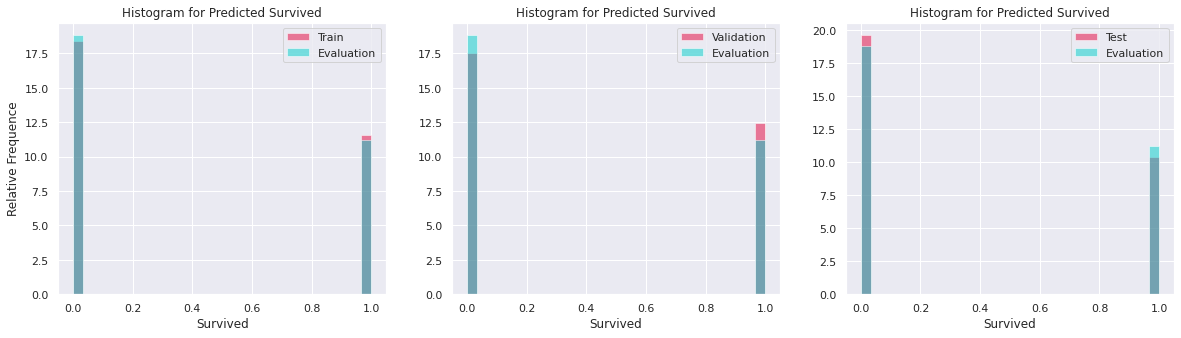

In [95]:
#  Load test data
df_evaluation = pd.read_csv("gender_submission.csv", sep=",")

# Make prediction over evaluation data
# predicted_prob_eva = rf_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
df_evaluation.iloc[:,1] = rf_grid.predict(X_sub)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 3)
plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.show()

# Export file to submit in competition
df_evaluation.to_csv(submissions_path + '/Titanic_RF_Jimenez_v1.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'rf'
df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation.Survived], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Light GBM technique

In [96]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/LGBM_model.pkl','rb')
  lgbm_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_LGBM.pkl','rb')
  best_params = pickle.load(infile)
else:
  #Define the grid to be searched in
  lgbm = LGBMClassifier(n_estimators=50, random_state = random_state)

  # Create the random grid
  parameters = {  'max_depth':[-1,1, 5, 10, 20, 30, 50]
                , 'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2] 
                , 'num_leaves':[10, 20,40,60,80]                               
                , 'reg_alpha':[0,0.01,0.03,0.1,0.5,1]                
                # , 'min_child_samples':[5,10,15,30,50,100,300,500]

                }

  #Execute cross-validated grid search
  lgbm_grid = TuneSearchCV(lgbm, param_distributions=parameters, n_trials = 30, early_stopping = False, n_jobs = -1, random_state = random_state )

  # Train Model
  lgbm_grid.fit(x_train,y_train)

  #Save model
  with open(models_path + '/LGBM_model.pkl', 'wb') as pickfile:
     pickle.dump(lgbm_grid, pickfile)
  with open(models_path + '/best_params_LGBM.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)
print("======================================================================================")
print("Best parameters found: ")
print(lgbm_grid.best_params_)

print("======================================================================================")

# predicted_prob_val = lgbm_grid.best_estimator_.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

# predicted_prob_train = lgbm_grid.best_estimator_.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = lgbm_grid.best_estimator_.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = lgbm_grid.best_estimator_.predict(x_train)

# Predict values of regression with validation
ypred_val = lgbm_grid.best_estimator_.predict(x_val)

# Predict values of regression with test
ypred_test = lgbm_grid.best_estimator_.predict(x_test)

print("Evaluating results of the classification:")
print("Accuracy Score for train, validation, test: {}, {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val), accuracy_score(y_test, ypred_test)))
print("Precision Score for train, validation, test: {}, {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val), precision_score(y_test, ypred_test)))
print("Recall Score for train, validation, test: {}, {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val), recall_score(y_test, ypred_test)))
print("F1 Score for train, validation, test: {}, {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val), f1_score(y_test, ypred_test)))
# print("AUROC for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val), roc_auc_score(y_test, predicted_prob_test)))
# print("GINI for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1, roc_auc_score(y_test, predicted_prob_test) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(lgbm_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (534, 1550)
Y Train shape: (534,)
X Validation shape: (178, 1550)
Y Validation shape: (178,)
X Test shape: (179, 1550)
Y Test shape: (179,)
Best parameters found: 
{'max_depth': 1, 'learning_rate': 0.1, 'num_leaves': 60, 'reg_alpha': 0.03}
Evaluating results of the classification:
Accuracy Score for train, validation, test: 0.8389513108614233, 0.8314606741573034, 0.8044692737430168
Precision Score for train, validation, test: 0.8225806451612904, 0.8235294117647058, 0.7454545454545455
Recall Score for train, validation, test: 0.7427184466019418, 0.7567567567567568, 0.6612903225806451
F1 Score for train, validation, test: 0.7806122448979592, 0.7887323943661971, 0.7008547008547009
Feature importance:
Ejecución: 0.11717820167541504 seconds


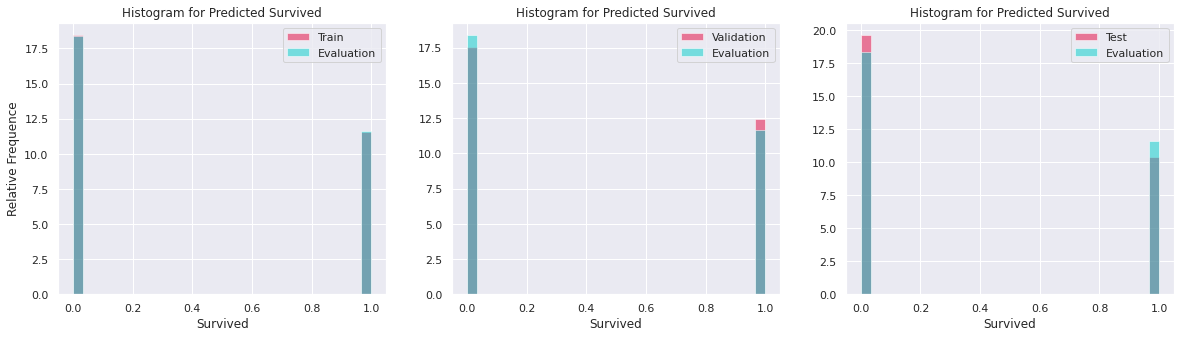

In [97]:
#  Load test data
df_evaluation = pd.read_csv("gender_submission.csv", sep=",")

# Make prediction over evaluation data
# predicted_prob_eva = lgbm_grid.best_estimator_.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
df_evaluation.iloc[:,1] = lgbm_grid.best_estimator_.predict(X_sub)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 3)
plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.show()

# Export file to submit in competition
df_evaluation.to_csv(submissions_path + '/Titanic_LGBM_Jimenez_v1.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'lgbm'
df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation.Survived], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Lasso regression technique

In [98]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/Lasso_model.pkl','rb')
  lasso_grid = pickle.load(infile)

else:
  #Define the grid to be searched in
  # lasso = Lasso(random_state = random_state)
  lasso = LogisticRegression(random_state = random_state, penalty='l1', solver='liblinear')
  # Create the random grid
  parameters = {'C':[1/1e-6, 1/1e-5, 1/1e-4, 1/1e-3, 1/5e-2, 1/1e-2, 1/1e-1, 1/0.3, 1/0.5, 1/0.7, 1/1.0, 1/10.0, 1/50.0, 1/100.0]}

  # Random search of parameters, using 5 fold cross validation, search across 100 different combinations, and use all available cores
  lasso_grid = RandomizedSearchCV(estimator = lasso, param_distributions = parameters, n_iter = 10, cv = 5, verbose=False, random_state = random_state, n_jobs = -1)
  # Fit the random search model
  lasso_grid.fit(x_train, y_train)

  #Save model
  with open(models_path + '/Lasso_model.pkl', 'wb') as pickfile:
     pickle.dump(lasso_grid, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(lasso_grid.best_params_)


print("======================================================================================")

# predicted_prob_val = lasso_grid.best_estimator_.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

# predicted_prob_train = lasso_grid.best_estimator_.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = lasso_grid.best_estimator_.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = lasso_grid.best_estimator_.predict(x_train)

# Predict values of regression with validation
ypred_val = lasso_grid.best_estimator_.predict(x_val)

# Predict values of regression with test
ypred_test = lasso_grid.best_estimator_.predict(x_test)

print("Evaluating results of the classification:")
print("Accuracy Score for train, validation, test: {}, {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val), accuracy_score(y_test, ypred_test)))
print("Precision Score for train, validation, test: {}, {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val), precision_score(y_test, ypred_test)))
print("Recall Score for train, validation, test: {}, {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val), recall_score(y_test, ypred_test)))
print("F1 Score for train, validation, test: {}, {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val), f1_score(y_test, ypred_test)))
# print("AUROC for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val), roc_auc_score(y_test, predicted_prob_test)))
# print("GINI for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1, roc_auc_score(y_test, predicted_prob_test) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(lasso_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (534, 1550)
Y Train shape: (534,)
X Validation shape: (178, 1550)
Y Validation shape: (178,)
X Test shape: (179, 1550)
Y Test shape: (179,)
Best parameters found: 
{'C': 2.0}
Evaluating results of the classification:
Accuracy Score for train, validation, test: 0.9700374531835206, 0.8033707865168539, 0.776536312849162
Precision Score for train, validation, test: 0.975, 0.7746478873239436, 0.6774193548387096
Recall Score for train, validation, test: 0.9466019417475728, 0.7432432432432432, 0.6774193548387096
F1 Score for train, validation, test: 0.9605911330049262, 0.7586206896551724, 0.6774193548387096
Feature importance:
Ejecución: 0.12373542785644531 seconds


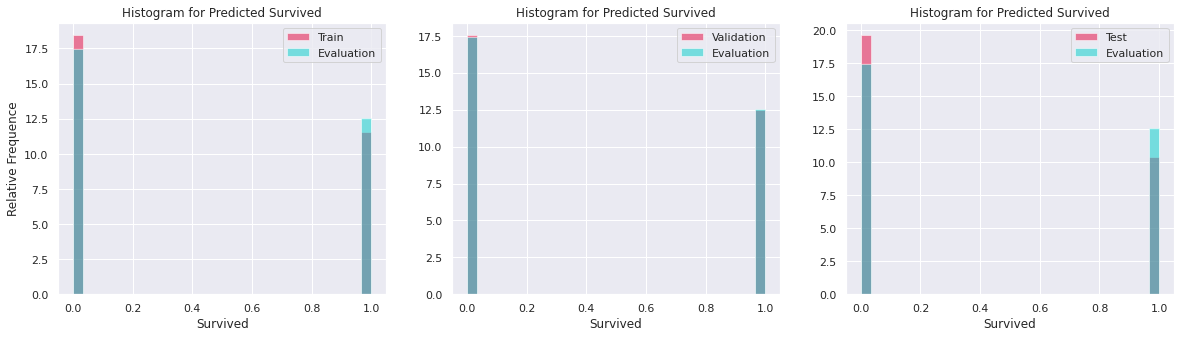

In [99]:
#  Load test data
df_evaluation = pd.read_csv("gender_submission.csv", sep=",")

# # Make prediction over evaluation data
# predicted_prob_eva = lasso_grid.best_estimator_.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
df_evaluation.iloc[:,1] = lasso_grid.best_estimator_.predict(X_sub)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 3)
plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.show()

# Export file to submit in competition
df_evaluation.to_csv(submissions_path + '/Titanic_LASSO_Jimenez_v2.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'lasso'
df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation.Survived], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Ridge regression technique

In [100]:
# Set flag to train or load model 
# To load the model then: load_model = 
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/ridge_model.pkl','rb')
  ridge_grid = pickle.load(infile)
else:
  #Define the grid to be searched in
  ridge = RidgeClassifier(random_state = random_state)

  # Create the random grid
  parameters = {'alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 0.3,0.7, 1.0, 10.0, 20.0, 30.0, 100.0]}
  # Random search of parameters, using 5 fold cross validation, search across 100 different combinations, and use all available cores
  ridge_grid = RandomizedSearchCV(estimator = ridge, param_distributions = parameters, n_iter = 10, cv = 5, verbose=False, random_state = random_state , n_jobs = -1)
  # Fit the random search model
  ridge_grid.fit(x_train, y_train)
  #Save model
  with open(models_path + '/ridge_model.pkl', 'wb') as pickfile:
     pickle.dump(ridge_grid, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(ridge_grid.best_params_)

print("======================================================================================")

# predicted_prob_val = ridge_grid.best_estimator_.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

# predicted_prob_train = ridge_grid.best_estimator_.predict(x_train)
# Predict values of regression with train
ypred_train = ridge_grid.best_estimator_.predict(x_train)

# Predict values of regression with validation
ypred_val = ridge_grid.best_estimator_.predict(x_val)

# predicted_prob_test = ridge_grid.best_estimator_.predict_proba(x_test)[:, 1]
# Predict values of regression with test
ypred_test = ridge_grid.best_estimator_.predict(x_test)

print("Evaluating results of the classification:")
print("Accuracy Score for train, validation, test: {}, {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val), accuracy_score(y_test, ypred_test)))
print("Precision Score for train, validation, test: {}, {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val), precision_score(y_test, ypred_test)))
print("Recall Score for train, validation, test: {}, {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val), recall_score(y_test, ypred_test)))
print("F1 Score for train, validation, test: {}, {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val), f1_score(y_test, ypred_test)))
# print("AUROC for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val), roc_auc_score(y_test, predicted_prob_test)))
# print("GINI for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1, roc_auc_score(y_test, predicted_prob_test) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(ridge_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (534, 1550)
Y Train shape: (534,)
X Validation shape: (178, 1550)
Y Validation shape: (178,)
X Test shape: (179, 1550)
Y Test shape: (179,)
Best parameters found: 
{'alpha': 10.0}
Evaluating results of the classification:
Accuracy Score for train, validation, test: 0.8764044943820225, 0.8314606741573034, 0.8044692737430168
Precision Score for train, validation, test: 0.868421052631579, 0.8333333333333334, 0.7368421052631579
Recall Score for train, validation, test: 0.8009708737864077, 0.7432432432432432, 0.6774193548387096
F1 Score for train, validation, test: 0.8333333333333333, 0.7857142857142858, 0.7058823529411764
Feature importance:
Ejecución: 0.13133811950683594 seconds


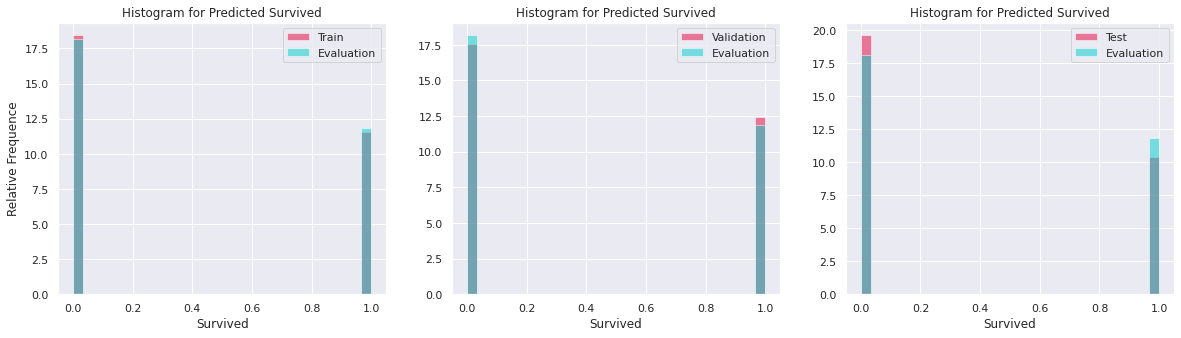

In [101]:
#  Load test data
df_evaluation = pd.read_csv("gender_submission.csv", sep=",")

# Make prediction over evaluation data
# predicted_prob_eva = lasso_grid.best_estimator_.predict_proba(X_sub)[:, 1]
# Predict values of regression with validation
df_evaluation.iloc[:,1] = ridge_grid.best_estimator_.predict(X_sub)


# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 3)
plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.show()

# Export file to submit in competition
df_evaluation.to_csv(submissions_path + '/Titanic_RIDGE_Jimenez_v2.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'ridge'
df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation.Survived], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Elastic net regression technique

In [102]:
# Set flag to train or load model 
# To load the model then: load_model = 
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/elasticnet_model.pkl','rb')
  elasticnet_grid = pickle.load(infile)
else:
  #Define the model
  elasticnet = LogisticRegression(random_state = random_state, penalty='elasticnet', solver = 'saga')

  # Create the random grid
  parameters = {'C':[1/1e-6, 1/1e-5, 1/1e-4, 1/1e-3, 1/5e-2, 1/1e-2, 1/1e-1, 1/0.3, 1/0.5, 1/0.7, 1/1.0, 1/10.0, 1/50.0, 1/100.0]
                ,'l1_ratio': np.arange(0, 1, 0.01)}
  # Random search of parameters, using 5 fold cross validation, search across 100 different combinations, and use all available cores
  elasticnet_grid = RandomizedSearchCV(estimator = elasticnet, param_distributions = parameters, n_iter = 10, cv = 5, verbose=False, random_state = random_state , n_jobs = -1)
  # Fit the random search model
  elasticnet_grid.fit(x_train, y_train)
  
  #Save model
  with open(models_path + '/elasticnet_model.pkl', 'wb') as pickfile:
     pickle.dump(elasticnet_grid, pickfile)
print("======================================================================================")
print("Best parameters found: ")
print(elasticnet_grid.best_params_)

print("======================================================================================")

# predicted_prob_val = elasticnet_grid.best_estimator_.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

# predicted_prob_train = elasticnet_grid.best_estimator_.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = elasticnet_grid.best_estimator_.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = elasticnet_grid.best_estimator_.predict(x_train)

# Predict values of regression with validation
ypred_val = elasticnet_grid.best_estimator_.predict(x_val)

# Predict values of regression with test
ypred_test = elasticnet_grid.best_estimator_.predict(x_test)

print("Evaluating results of the classification:")
print("Accuracy Score for train, validation, test: {}, {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val), accuracy_score(y_test, ypred_test)))
print("Precision Score for train, validation, test: {}, {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val), precision_score(y_test, ypred_test)))
print("Recall Score for train, validation, test: {}, {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val), recall_score(y_test, ypred_test)))
print("F1 Score for train, validation, test: {}, {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val), f1_score(y_test, ypred_test)))
# print("AUROC for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val), roc_auc_score(y_test, predicted_prob_test)))
# print("GINI for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1, roc_auc_score(y_test, predicted_prob_test) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(elasticnet_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (534, 1550)
Y Train shape: (534,)
X Validation shape: (178, 1550)
Y Validation shape: (178,)
X Test shape: (179, 1550)
Y Test shape: (179,)
Best parameters found: 
{'l1_ratio': 0.84, 'C': 10.0}
Evaluating results of the classification:
Accuracy Score for train, validation, test: 0.7322097378277154, 0.6741573033707865, 0.7486033519553073
Precision Score for train, validation, test: 0.7787610619469026, 0.7857142857142857, 0.7575757575757576
Recall Score for train, validation, test: 0.42718446601941745, 0.2972972972972973, 0.4032258064516129
F1 Score for train, validation, test: 0.5517241379310345, 0.43137254901960786, 0.5263157894736842
Feature importance:
Ejecución: 0.18306255340576172 seconds


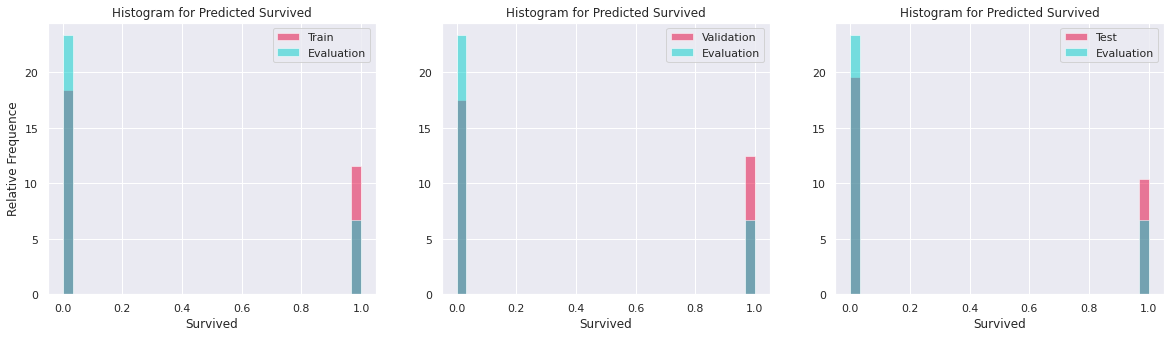

In [103]:
#  Load test data
df_evaluation = pd.read_csv("gender_submission.csv", sep=",")

# Make prediction over evaluation data
# predicted_prob_eva = elasticnet_grid.best_estimator_.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
df_evaluation.iloc[:,1] = elasticnet_grid.best_estimator_.predict(X_sub)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 3)
plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.show()

# Export file to submit in competition
df_evaluation.to_csv(submissions_path + '/Titanic_ENET_Jimenez_v2.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'enet'
df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation.Survived], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Support Vector Machine technique

In [104]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/SVM_model.pkl','rb')
  svm_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_SVM.pkl','rb')
  best_params = pickle.load(infile)
else:
  # Define function to minimize  
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      
      # Use params to create new model
      model = make_pipeline(RobustScaler(), SVC(probability=True, cache_size=7000, **params))
     
      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1,error_score='raise').mean()

      return score

  # Define grid (space)
  parameters = {'C': hp.choice('C', [0.01, 0.1, 1, 10, 20, 100])
                , 'kernel': hp.choice('kernel',['poly', 'rbf', 'sigmoid'])
                , 'degree':hp.choice('degree',[2,3,4])
                # , 'gamma': hp.choice('gamma',[1, 0.1, 0.01, 0.001])
      }
  # Minimize function
  best = fmin(fn = param_selection_cv, 
            space = parameters, 
            algo = tpe.suggest, 
            max_evals = 30
            , rstate = np.random.RandomState(random_state)
          )
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)
  
  # Define model with best hyperparameters
  svm_grid = make_pipeline(RobustScaler(), SVC(probability=True, cache_size=7000, C=best_params['C']
                                               , kernel=best_params['kernel']
                                              #  , gamma=best_params['gamma']
                                                , degree=best_params['degree']
                                               ))
  # Train model
  svm_grid.fit(x_train,y_train)

  #Save model
  with open(models_path + '/SVM_model.pkl', 'wb') as pickfile:
     pickle.dump(svm_grid, pickfile)
  with open(models_path + '/best_params_SVM.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")

# predicted_prob_val = svm_grid.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

# predicted_prob_train = svm_grid.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = svm_grid.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = svm_grid.predict(x_train)

# Predict values of regression with validation
ypred_val = svm_grid.predict(x_val)

# Predict values of regression with test
ypred_test = svm_grid.predict(x_test)

print("Evaluating results of the classification:")
print("Accuracy Score for train, validation, test: {}, {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val), accuracy_score(y_test, ypred_test)))
print("Precision Score for train, validation, test: {}, {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val), precision_score(y_test, ypred_test)))
print("Recall Score for train, validation, test: {}, {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val), recall_score(y_test, ypred_test)))
print("F1 Score for train, validation, test: {}, {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val), f1_score(y_test, ypred_test)))
# print("AUROC for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val), roc_auc_score(y_test, predicted_prob_test)))
# print("GINI for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1, roc_auc_score(y_test, predicted_prob_test) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(svm_grid, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (534, 1550)
Y Train shape: (534,)
X Validation shape: (178, 1550)
Y Validation shape: (178,)
X Test shape: (179, 1550)
Y Test shape: (179,)
Best parameters found: 
{'C': 1, 'degree': 4, 'kernel': 'rbf'}
Evaluating results of the classification:
Accuracy Score for train, validation, test: 0.846441947565543, 0.8370786516853933, 0.7988826815642458
Precision Score for train, validation, test: 0.8229166666666666, 0.835820895522388, 0.7241379310344828
Recall Score for train, validation, test: 0.7669902912621359, 0.7567567567567568, 0.6774193548387096
F1 Score for train, validation, test: 0.7939698492462312, 0.7943262411347517, 0.7
Feature importance:
Ejecución: 0.7406702041625977 seconds


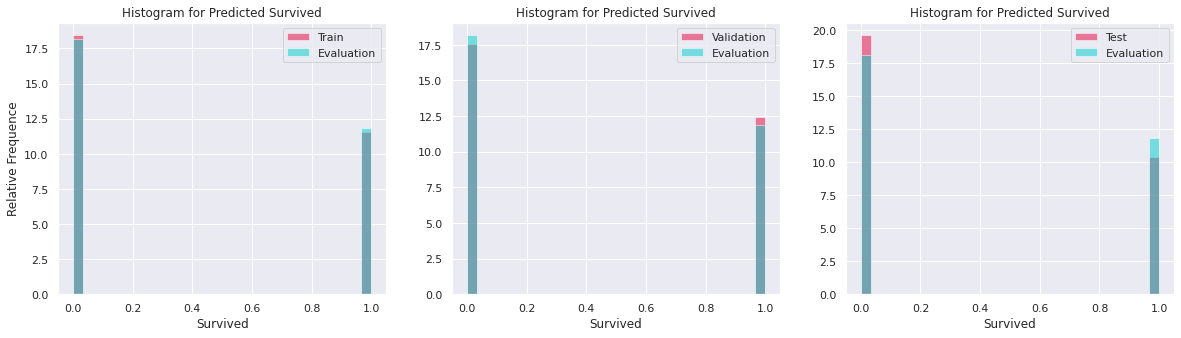

In [105]:
#  Load test data
df_evaluation = pd.read_csv("gender_submission.csv", sep=",")

# Make prediction over evaluation data
# predicted_prob_eva = svm_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
df_evaluation.iloc[:,1] = svm_grid.predict(X_sub)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 3)
plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.show()

# Export file to submit in competition
df_evaluation.to_csv(submissions_path + '/Titanic_SVM_Jimenez_v2.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'svm'
df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation.Survived], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Gradient Boosting technique

In [106]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/GradientBoost_model.pkl','rb')
  gb_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_GradientBoost.pkl','rb')
  best_params = pickle.load(infile)
else:
    # Define function to minimize
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      
      # Use params to create new model
      model = make_pipeline( GradientBoostingClassifier(random_state = random_state, **params))

      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Define grid (space)
  parameters = {'max_depth': hp.choice('max_depth', range(3,20,1))
        , 'min_samples_split': hp.choice('min_samples_split', range(1,10,1))
        , 'n_estimators': hp.choice('n_estimators', [300])
        # , 'max_leaf_nodes': hp.choice('max_leaf_nodes', [2, 5, 10, 20, 50, 100])
        # , 'min_samples_leaf': hp.choice('min_samples_leaf', range(10,71,10))
        # , 'learning_rate': hp.choice('learning_rate', [0.0001, 0.001, 0.01, 0.1, 0.2] )

    }

  # Minimize function
  best = fmin(fn = param_selection_cv 
            , space = parameters 
            , algo = tpe.suggest 
            , max_evals = 10
            , rstate = np.random.RandomState(random_state)
          )
  
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)

  # Define model with best hyperparameters
  gb_grid = make_pipeline( GradientBoostingClassifier(random_state = random_state, **best_params))

  # Train Model
  gb_grid.fit(x_train,y_train)

  #Save model
  with open(models_path + '/GradientBoost_model.pkl', 'wb') as pickfile:
     pickle.dump(gb_grid, pickfile)
  with open(models_path + '/best_params_GradientBoost.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)
     
print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")

# predicted_prob_val = gb_grid.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

# predicted_prob_train = gb_grid.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = gb_grid.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = gb_grid.predict(x_train)

# Predict values of regression with validation
ypred_val = gb_grid.predict(x_val)

# Predict values of regression with test
ypred_test = gb_grid.predict(x_test)


print("Evaluating results of the classification:")
print("Accuracy Score for train, validation, test: {}, {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val), accuracy_score(y_test, ypred_test)))
print("Precision Score for train, validation, test: {}, {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val), precision_score(y_test, ypred_test)))
print("Recall Score for train, validation, test: {}, {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val), recall_score(y_test, ypred_test)))
print("F1 Score for train, validation, test: {}, {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val), f1_score(y_test, ypred_test)))
# print("AUROC for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val), roc_auc_score(y_test, predicted_prob_test)))
# print("GINI for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1, roc_auc_score(y_test, predicted_prob_test) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(gb_grid, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (534, 1550)
Y Train shape: (534,)
X Validation shape: (178, 1550)
Y Validation shape: (178,)
X Test shape: (179, 1550)
Y Test shape: (179,)
Best parameters found: 
{'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 300}
Evaluating results of the classification:
Accuracy Score for train, validation, test: 1.0, 0.8146067415730337, 0.7821229050279329
Precision Score for train, validation, test: 1.0, 0.7887323943661971, 0.6825396825396826
Recall Score for train, validation, test: 1.0, 0.7567567567567568, 0.6935483870967742
F1 Score for train, validation, test: 1.0, 0.7724137931034482, 0.6880000000000001
Feature importance:
Ejecución: 0.16909122467041016 seconds


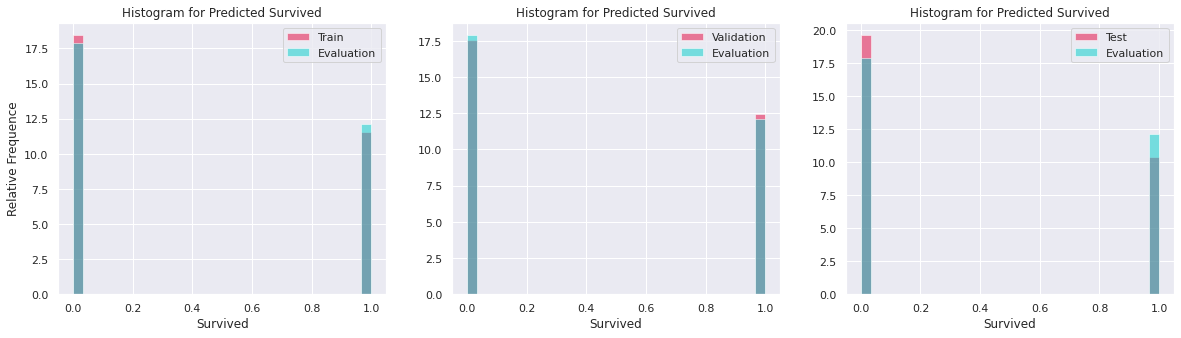

In [107]:
#  Load test data
df_evaluation = pd.read_csv("gender_submission.csv", sep=",")

# Make prediction over evaluation data
# predicted_prob_eva = gb_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
df_evaluation.iloc[:,1] = gb_grid.predict(X_sub)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 3)
plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.show()

# Export file to submit in competition
df_evaluation.to_csv(submissions_path + '/Titanic_GB_Jimenez_v2.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'gb'
df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation.Survived], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Cat Boost technique

In [108]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/CatBoost_model.pkl','rb')
  cat_model_f = pickle.load(infile)
  infile = open(models_path + '/params_CatBoost_model.pkl','rb')
  best_params = pickle.load(infile)

else:
  # Define function to minimize
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      
      # Use params to create new model
      model = make_pipeline( CatBoostClassifier(random_state = random_state, **params))

      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Define grid (space)
  # parameters = {'iterations': hp.choice('iterations', [1000,6000])
  parameters = {'iterations': hp.choice('iterations', [250,100,500,1000, 2000])
        , 'eval_metric': hp.choice('eval_metric', ['Accuracy'])
        , 'early_stopping_rounds': hp.choice('early_stopping_rounds', [200])
        , 'learning_rate': hp.choice('learning_rate', [0.05, 0.005, 0.0005])
        , 'l2_leaf_reg': hp.choice('l2_leaf_reg', [1, 3, 5, 9])
        # , 'depth': hp.choice('depth', [4, 6, 10])
    }
# 
  # Minimize function
  best = fmin(fn = param_selection_cv 
            , space = parameters 
            , algo = tpe.suggest 
            , max_evals = 10
            , rstate = np.random.RandomState(random_state)
          )
  
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)

  # Define model with best hyperparameters
  cat_f = make_pipeline( CatBoostClassifier(random_state = random_state, **best_params))  

  # Train model  
  cat_model_f = cat_f.fit(x_train,y_train)

  #Save model
  with open(models_path + '/CatBoost_model.pkl', 'wb') as pickfile:
     pickle.dump(cat_model_f, pickfile)
  with open(models_path + '/params_CatBoost_model.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")

# predicted_prob_val = cat_model_f.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

# predicted_prob_train = cat_model_f.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = cat_model_f.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = cat_model_f.predict(x_train)

# Predict values of regression with validation
ypred_val = cat_model_f.predict(x_val)

# Predict values of regression with test
ypred_test = cat_model_f.predict(x_test)

print("Evaluating results of the classification:")
print("Accuracy Score for train, validation, test: {}, {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val), accuracy_score(y_test, ypred_test)))
print("Precision Score for train, validation, test: {}, {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val), precision_score(y_test, ypred_test)))
print("Recall Score for train, validation, test: {}, {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val), recall_score(y_test, ypred_test)))
print("F1 Score for train, validation, test: {}, {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val), f1_score(y_test, ypred_test)))
# print("AUROC for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val), roc_auc_score(y_test, predicted_prob_test)))
# print("GINI for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1, roc_auc_score(y_test, predicted_prob_test) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(cat_model_f, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (534, 1550)
Y Train shape: (534,)
X Validation shape: (178, 1550)
Y Validation shape: (178,)
X Test shape: (179, 1550)
Y Test shape: (179,)
Best parameters found: 
{'early_stopping_rounds': 200, 'eval_metric': 'Accuracy', 'iterations': 500, 'l2_leaf_reg': 9, 'learning_rate': 0.005}
Evaluating results of the classification:
Accuracy Score for train, validation, test: 0.8445692883895131, 0.8258426966292135, 0.7988826815642458
Precision Score for train, validation, test: 0.8186528497409327, 0.8028169014084507, 0.7321428571428571
Recall Score for train, validation, test: 0.7669902912621359, 0.7702702702702703, 0.6612903225806451
F1 Score for train, validation, test: 0.7919799498746868, 0.7862068965517242, 0.6949152542372881
Feature importance:
Ejecución: 0.3189547061920166 seconds


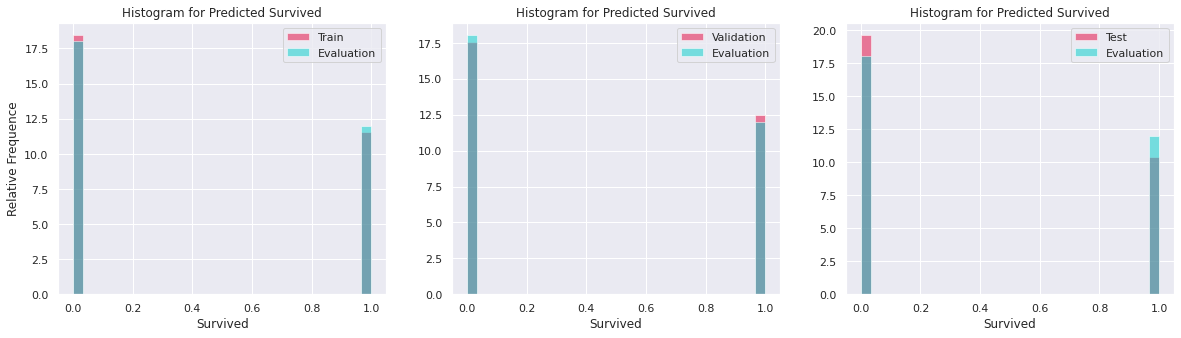

In [109]:
#  Load test data
df_evaluation = pd.read_csv("gender_submission.csv", sep=",")

# Make prediction over evaluation data
# predicted_prob_eva = cat_model_f.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
df_evaluation.iloc[:,1] = cat_model_f.predict(X_sub)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 3)
plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.show()

# Export file to submit in competition
df_evaluation.to_csv(submissions_path + '/Titanic_CATBOOST_Jimenez_v2.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'catboost'
df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation.Survived], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Artificial Neural Network technique

In [110]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/ANN_model.pkl','rb')
  ann_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_ANN.pkl','rb')
  best_params = pickle.load(infile)
else:
  # Define function to minimize  
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      # print(params)
      # Use params to create new model
      model = make_pipeline(RobustScaler(), MLPClassifier(random_state=random_state, max_iter=300, **params, early_stopping= True))
     
      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1,error_score='raise').mean()

      return score

  # Define grid (space)
  parameters = {'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(50,), (100,), (300,), (50,50,50), (100,100,100), (300,300,300), (50,100,50), (100,300,100), (300,100,300), (500,500,500,500)])
                #  'hidden_layer_sizes': 100 + hp.randint('hidden_layer_sizes', 40)
                # , 'alpha': hp.loguniform('alpha', -8*np.log(10), 3*np.log(10))
                , 'alpha': hp.choice('alpha', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]) 
                , 'activation':hp.choice('activation', ['relu', 'logistic', 'tanh'])
                , 'solver': hp.choice('solver', ['lbfgs', 'adam'])
                , 'learning_rate': hp.choice('learning_rate', ['invscaling', 'constant','adaptive'])
      }
 
  # Minimize function
  best = fmin(fn = param_selection_cv, 
            space = parameters, 
            algo = tpe.suggest, 
            max_evals = 15
            , rstate = np.random.RandomState(random_state)
          )
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)
  
  ann_grid = make_pipeline(RobustScaler(), MLPClassifier(random_state=random_state, max_iter=300, **best_params, early_stopping= True))

  # Train model
  ann_grid.fit(x_train,y_train)

  #Save model
  with open(models_path + '/ANN_model.pkl', 'wb') as pickfile:
     pickle.dump(ann_grid, pickfile)
  with open(models_path + '/best_params_ANN.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")

# predicted_prob_val = ann_grid.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

# predicted_prob_train = ann_grid.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = ann_grid.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = ann_grid.predict(x_train)

# Predict values of regression with validation
ypred_val = ann_grid.predict(x_val)

# Predict values of regression with test
ypred_test = ann_grid.predict(x_test)

print("Evaluating results of the classification:")
print("Accuracy Score for train, validation, test: {}, {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val), accuracy_score(y_test, ypred_test)))
print("Precision Score for train, validation, test: {}, {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val), precision_score(y_test, ypred_test)))
print("Recall Score for train, validation, test: {}, {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val), recall_score(y_test, ypred_test)))
print("F1 Score for train, validation, test: {}, {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val), f1_score(y_test, ypred_test)))
# print("AUROC for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val), roc_auc_score(y_test, predicted_prob_test)))
# print("GINI for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1, roc_auc_score(y_test, predicted_prob_test) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(ann_grid, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (534, 1550)
Y Train shape: (534,)
X Validation shape: (178, 1550)
Y Validation shape: (178,)
X Test shape: (179, 1550)
Y Test shape: (179,)
Best parameters found: 
{'activation': 'tanh', 'alpha': 10.0, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'solver': 'lbfgs'}
Evaluating results of the classification:
Accuracy Score for train, validation, test: 0.8932584269662921, 0.8370786516853933, 0.8100558659217877
Precision Score for train, validation, test: 0.8941798941798942, 0.8461538461538461, 0.7333333333333333
Recall Score for train, validation, test: 0.8203883495145631, 0.7432432432432432, 0.7096774193548387
F1 Score for train, validation, test: 0.8556962025316455, 0.7913669064748202, 0.7213114754098361
Feature importance:
Ejecución: 0.12671113014221191 seconds


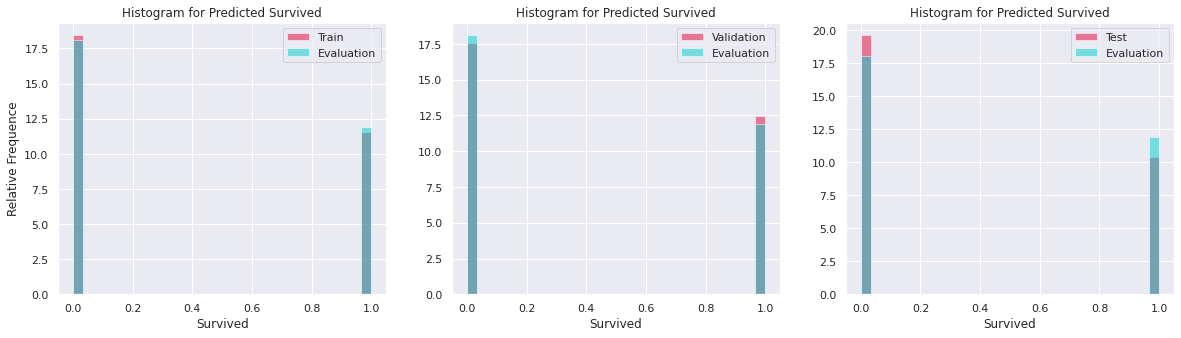

In [111]:
#  Load test data
df_evaluation = pd.read_csv("gender_submission.csv", sep=",")

# Make prediction over evaluation data
# predicted_prob_eva = ann_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
df_evaluation.iloc[:,1] = ann_grid.predict(X_sub)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 3)
plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.show()

# Export file to submit in competition
df_evaluation.to_csv(submissions_path + '/Titanic_ANN_Jimenez_v2.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'ann'
df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation.Survived], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Decision Tree technique

In [112]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/DT_model.pkl','rb')
  dt_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_DT.pkl','rb')
  best_params = pickle.load(infile)
else:
  # Define function to minimize
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      # Use params to create new model
      model = make_pipeline( DecisionTreeClassifier(random_state = random_state, **params))
      
      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Define grid (space)
  parameters = {'max_depth': hp.choice('max_depth', range(3,20,1))
        , 'min_samples_leaf': hp.choice('min_samples_leaf', [0.001, 0.01, 0.1, 0.2, 0.5, 1, 10, 50, 100, ])
        , 'max_features' : hp.choice('max_features', [0.2, 0.4,0.6, 0.8, "auto","log2","sqrt",None])
        , 'splitter':hp.choice('splitter', ["best","random"])
        , "max_leaf_nodes":hp.choice('max_leaf_nodes', [None,10,20,30,40,50,60,70,80,90])
        # , "min_weight_fraction_leaf":hp.choice('min_weight_fraction_leaf', [0.001, 0.01, 0.1,0.2,0.3,0.4,0.5])
    }

  # Minimize function
  best = fmin(fn = param_selection_cv 
            , space = parameters 
            , algo = tpe.suggest 
            , max_evals = 20
            , rstate = np.random.RandomState(random_state)
          )
  
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)

  # Define model with best hyperparameters
  dt_grid = make_pipeline( DecisionTreeClassifier(random_state = random_state, **best_params))

  # Train Model
  dt_grid.fit(x_train,y_train)
  
  #Save model
  with open(models_path + '/DT_model.pkl', 'wb') as pickfile:
     pickle.dump(dt_grid, pickfile)
  with open(models_path + '/best_params_DT.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)
print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")

# predicted_prob_val = dt_grid.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

# predicted_prob_train = dt_grid.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = dt_grid.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = dt_grid.predict(x_train)

# Predict values of regression with validation
ypred_val = dt_grid.predict(x_val)

# Predict values of regression with test
ypred_test = dt_grid.predict(x_test)

print("Evaluating results of the classification:")
print("Accuracy Score for train, validation, test: {}, {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val), accuracy_score(y_test, ypred_test)))
print("Precision Score for train, validation, test: {}, {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val), precision_score(y_test, ypred_test)))
print("Recall Score for train, validation, test: {}, {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val), recall_score(y_test, ypred_test)))
print("F1 Score for train, validation, test: {}, {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val), f1_score(y_test, ypred_test)))
# print("AUROC for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val), roc_auc_score(y_test, predicted_prob_test)))
# print("GINI for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1, roc_auc_score(y_test, predicted_prob_test) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(dt_grid, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (534, 1550)
Y Train shape: (534,)
X Validation shape: (178, 1550)
Y Validation shape: (178,)
X Test shape: (179, 1550)
Y Test shape: (179,)
Best parameters found: 
{'max_depth': 11, 'max_features': 0.2, 'max_leaf_nodes': 80, 'min_samples_leaf': 1, 'splitter': 'random'}
Evaluating results of the classification:
Accuracy Score for train, validation, test: 0.9138576779026217, 0.7808988764044944, 0.7653631284916201
Precision Score for train, validation, test: 0.8669724770642202, 0.7272727272727273, 0.65625
Recall Score for train, validation, test: 0.9174757281553398, 0.7567567567567568, 0.6774193548387096
F1 Score for train, validation, test: 0.8915094339622642, 0.7417218543046358, 0.6666666666666667
Feature importance:
Ejecución: 0.06870150566101074 seconds


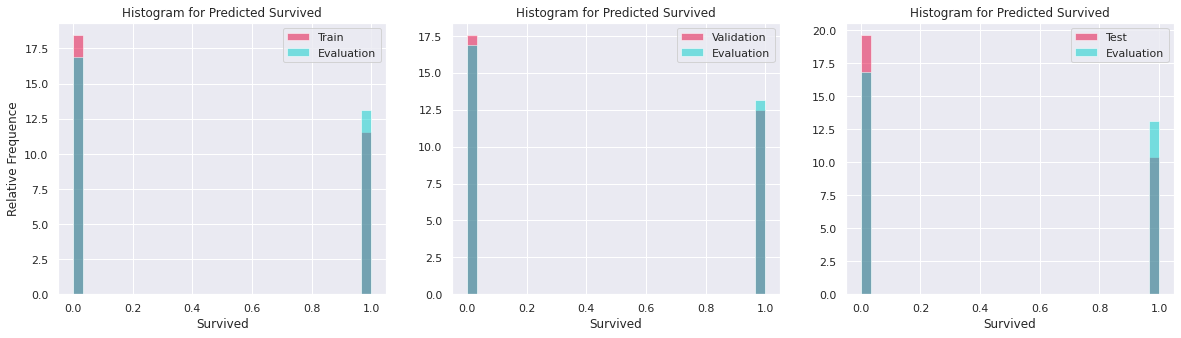

In [113]:
#  Load test data
df_evaluation = pd.read_csv("gender_submission.csv", sep=",")

# Make prediction over evaluation data
# predicted_prob_eva = dt_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
df_evaluation.iloc[:,1] = dt_grid.predict(X_sub)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 3)
plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.show()

# Export file to submit in competition
df_evaluation.to_csv(submissions_path + '/Titanic_DT_Jimenez_v2.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'dt'
df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation.Survived], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Stacking models

# With XGBoost as meta model

In [133]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model and weights
  infile = open(models_path + '/Stacked_meta_XGBoost_model.pkl','rb')
  stack_gen_model_xgb = pickle.load(infile)
  # infile = open(models_path + '/weights_meta_XGBoost_model.pkl','rb')
  # best_w = pickle.load(infile)
  # infile = open(models_path + '/rmse_meta_XGBoost_model.pkl','rb')
  # best_rmse_w = pickle.load(infile)

else:
  # Stacking - combine multiple regression models with a meta-regressor. 
  stack_gen = StackingCVClassifier(classifiers=(ridge_grid.best_estimator_, lasso_grid.best_estimator_, svm_grid,  gb_grid, xgb_grid
                                            , lgbm_grid.best_estimator_, rf_grid, cat_model_f
                                            # , elasticnet_grid.best_estimator_
                                            , ann_grid
                                            # , dt_grid
                                            ),
                                meta_classifier=xgb_grid,
                                use_features_in_secondary=True
                                )
  # Train stacked model
  stack_gen_model_xgb = stack_gen.fit(x_train.values, y_train.values)
  # Calculate best weights for stacked prediction 
  # best_w, best_rmse_w = get_best_weights(x_val, number_models = 10, n_trials = 100)
  
  #Save model and weights
  with open(models_path + '/Stacked_meta_XGBoost_model.pkl', 'wb') as pickfile:
     pickle.dump(stack_gen_model_xgb, pickfile)
  # with open(models_path + '/weights_meta_XGBoost_model.pkl', 'wb') as pickfile:
  #    pickle.dump(best_w, pickfile)
  # with open(models_path + '/rmse_meta_XGBoost_model.pkl', 'wb') as pickfile:
  #    pickle.dump(best_rmse_w, pickfile)

print("======================================================================================")
# print("The best weighs are:", best_w)
# print("The best rmse in validation was:", best_rmse_w)

print("======================================================================================")
# # Predict values of regression with train
# ypred_train = ensemble_models_predict(x_train, best_w)
# # Predict values of regression with validation
# ypred_val = ensemble_models_predict(x_val, best_w)
# # Predict values of regression with test
# ypred_test = ensemble_models_predict(x_test, best_w)

# Predict values of regression with train
ypred_train = stack_gen_model_xgb.predict(x_train.values)

# Predict values of regression with validation
ypred_val = stack_gen_model_xgb.predict(x_val.values)

# Predict values of regression with test
ypred_test = stack_gen_model_xgb.predict(x_test.values)

print("Evaluating results of the classification:")
print("Accuracy Score for train, validation, test: {}, {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val), accuracy_score(y_test, ypred_test)))
print("Precision Score for train, validation, test: {}, {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val), precision_score(y_test, ypred_test)))
print("Recall Score for train, validation, test: {}, {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val), recall_score(y_test, ypred_test)))
print("F1 Score for train, validation, test: {}, {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val), f1_score(y_test, ypred_test)))
# print("AUROC for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val), roc_auc_score(y_test, predicted_prob_test)))
# print("GINI for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1, roc_auc_score(y_test, predicted_prob_test) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(stack_gen_model_xgb, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)


print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (534, 1550)
Y Train shape: (534,)
X Validation shape: (178, 1550)
Y Validation shape: (178,)
X Test shape: (179, 1550)
Y Test shape: (179,)
0:	learn: 0.8202247	total: 3.21ms	remaining: 1.6s
1:	learn: 0.7827715	total: 5.46ms	remaining: 1.36s
2:	learn: 0.7827715	total: 7.08ms	remaining: 1.17s
3:	learn: 0.8089888	total: 9.28ms	remaining: 1.15s
4:	learn: 0.7940075	total: 12.7ms	remaining: 1.26s
5:	learn: 0.7902622	total: 14.9ms	remaining: 1.23s
6:	learn: 0.7940075	total: 17.1ms	remaining: 1.2s
7:	learn: 0.7940075	total: 19.3ms	remaining: 1.19s
8:	learn: 0.7940075	total: 22.9ms	remaining: 1.25s
9:	learn: 0.7977528	total: 28.2ms	remaining: 1.38s
10:	learn: 0.7977528	total: 36.3ms	remaining: 1.61s
11:	learn: 0.7977528	total: 42.6ms	remaining: 1.73s
12:	learn: 0.7977528	total: 46.5ms	remaining: 1.74s
13:	learn: 0.7977528	total: 50ms	remaining: 1.74s
14:	learn: 0.7977528	total: 54.7ms	remaining: 1.77s
15:	learn: 0.7977528	total: 62.1ms	remaining: 1.88s
16:	learn: 0.7977528	total:

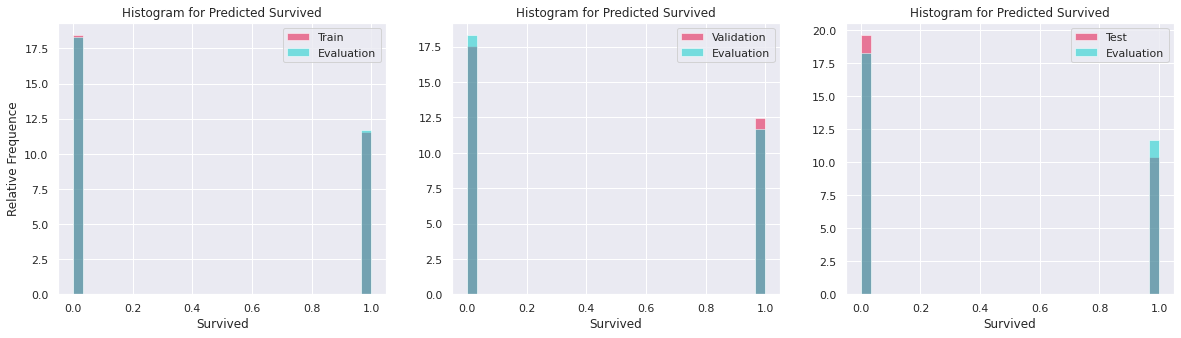

In [134]:
#  Load test data
df_evaluation = pd.read_csv("gender_submission.csv", sep=",")

# Make prediction over evaluation data
# predicted_prob_eva = stack_gen_model_xgb.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
df_evaluation.iloc[:,1] = stack_gen_model_xgb.predict(np.array(X_sub))

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 3)
plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.show()

# Export file to submit in competition
df_evaluation.to_csv(submissions_path + '/Titanic_ENSEMBLE_XGBoost_Jimenez_v4.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'ens_xgb'
df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation.Survived], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# With Random Forest as meta model

In [135]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model and weights
  infile = open(models_path + '/Stacked_meta_RF_model.pkl','rb')
  stack_gen_model_rf = pickle.load(infile)
  # infile = open(models_path + '/weights_meta_RF_model.pkl','rb')
  # best_w = pickle.load(infile)
  # infile = open(models_path + '/rmse_meta_RF_model.pkl','rb')
  # best_rmse_w = pickle.load(infile)

else:
  # Stacking - combine multiple regression models with a meta-regressor. 
  stack_gen = StackingCVClassifier(classifiers=(ridge_grid.best_estimator_, lasso_grid.best_estimator_, svm_grid,  gb_grid, xgb_grid
                                            , lgbm_grid.best_estimator_, rf_grid, cat_model_f
                                            # , elasticnet_grid.best_estimator_
                                            , ann_grid
                                            # , dt_grid
                                            ),
                                meta_classifier=rf_grid,
                                use_features_in_secondary=True
                                )
  # Train stacked model
  stack_gen_model_rf = stack_gen.fit(x_train.values, y_train.values)
  # Calculate best weights for stacked prediction 
  # best_w, best_rmse_w = get_best_weights(x_val, number_models = 10, n_trials = 100)
  
  #Save model and weights
  with open(models_path + '/Stacked_meta_RF_model.pkl', 'wb') as pickfile:
     pickle.dump(stack_gen_model_rf, pickfile)
  # with open(models_path + '/weights_meta_RF_model.pkl', 'wb') as pickfile:
  #    pickle.dump(best_w, pickfile)
  # with open(models_path + '/rmse_meta_RF_model.pkl', 'wb') as pickfile:
  #    pickle.dump(best_rmse_w, pickfile)

print("======================================================================================")
# print("The best weighs are:", best_w)
# print("The best rmse in validation was:", best_rmse_w)

print("======================================================================================")
# # Predict values of regression with train
# ypred_train = ensemble_models_predict(x_train, best_w)
# # Predict values of regression with validation
# ypred_val = ensemble_models_predict(x_val, best_w)
# # Predict values of regression with test
# ypred_test = ensemble_models_predict(x_test, best_w)

# Predict values of regression with train
ypred_train = stack_gen_model_rf.predict(x_train.values)

# Predict values of regression with validation
ypred_val = stack_gen_model_rf.predict(x_val.values)

# Predict values of regression with test
ypred_test = stack_gen_model_rf.predict(x_test.values)

print("Evaluating results of the classification:")
print("Accuracy Score for train, validation, test: {}, {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val), accuracy_score(y_test, ypred_test)))
print("Precision Score for train, validation, test: {}, {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val), precision_score(y_test, ypred_test)))
print("Recall Score for train, validation, test: {}, {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val), recall_score(y_test, ypred_test)))
print("F1 Score for train, validation, test: {}, {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val), f1_score(y_test, ypred_test)))
# print("AUROC for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val), roc_auc_score(y_test, predicted_prob_test)))
# print("GINI for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1, roc_auc_score(y_test, predicted_prob_test) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(stack_gen_model_rf, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)


print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (534, 1550)
Y Train shape: (534,)
X Validation shape: (178, 1550)
Y Validation shape: (178,)
X Test shape: (179, 1550)
Y Test shape: (179,)
0:	learn: 0.8052434	total: 2.48ms	remaining: 1.24s
1:	learn: 0.8014981	total: 4.71ms	remaining: 1.17s
2:	learn: 0.8052434	total: 6.85ms	remaining: 1.13s
3:	learn: 0.8014981	total: 8.98ms	remaining: 1.11s
4:	learn: 0.8052434	total: 11.2ms	remaining: 1.11s
5:	learn: 0.8052434	total: 13.3ms	remaining: 1.09s
6:	learn: 0.8052434	total: 15.4ms	remaining: 1.08s
7:	learn: 0.8052434	total: 17.5ms	remaining: 1.08s
8:	learn: 0.8052434	total: 19.6ms	remaining: 1.07s
9:	learn: 0.8089888	total: 24.6ms	remaining: 1.21s
10:	learn: 0.7977528	total: 27.3ms	remaining: 1.21s
11:	learn: 0.8014981	total: 31.9ms	remaining: 1.29s
12:	learn: 0.8089888	total: 37.8ms	remaining: 1.41s
13:	learn: 0.8052434	total: 39.9ms	remaining: 1.39s
14:	learn: 0.8052434	total: 42.1ms	remaining: 1.36s
15:	learn: 0.7977528	total: 44.2ms	remaining: 1.34s
16:	learn: 0.7977528	to

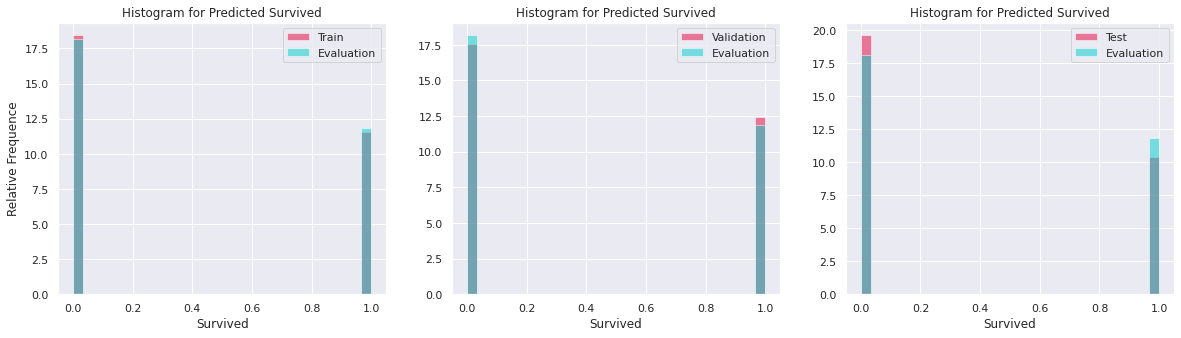

In [136]:
#  Load test data
df_evaluation = pd.read_csv("gender_submission.csv", sep=",")

# Make prediction over evaluation data
# predicted_prob_eva = stack_gen_model_rf.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
df_evaluation.iloc[:,1] = stack_gen_model_rf.predict(np.array(X_sub))

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 3)
plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.show()

# Export file to submit in competition
df_evaluation.to_csv(submissions_path + '/Titanic_ENSEMBLE_RF_Jimenez_v4.csv', index = False)

# Stack each model for ensemble method
curr_mod = 'ens_rf'
df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
df_eva_ens = pd.concat([df_eva_ens, df_evaluation.Survived], axis=1)
df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Own Voting ensemble

In [122]:
list_models = df_train_ens.columns
list_models

Index(['xgb', 'rf', 'lgbm', 'lasso', 'ridge', 'enet', 'svm', 'gb', 'catboost', 'ann', 'dt', 'ens_xgb', 'ens_rf'], dtype='object')

In [123]:
possible_combs = get_all_combinations(list_models)
print(len(possible_combs))
seed(random_state)
possible_combs = sample(possible_combs, 819)

8192


In [124]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model and weights
  infile = open(models_path + '/best_val_acc_own_voting.pkl','rb')
  best_val_acc = pickle.load(infile)
  infile = open(models_path + '/best_train_acc_own_voting.pkl','rb')
  best_train_acc = pickle.load(infile)
  infile = open(models_path + '/best_test_acc_own_voting.pkl','rb')
  best_test_acc = pickle.load(infile)
  infile = open(models_path + '/eva_pred_voting.pkl','rb')
  eva_pred = pickle.load(infile)
  infile = open(models_path + '/best_comb_own_voting.pkl','rb')
  best_comb = pickle.load(infile)

else:
  best_val_acc = 0

  for i in tqdm(possible_combs):
    if len(list(i)) > 1:
      mode_train = df_train_ens[list(i)].mode(axis=1)[0]
      # print(len(mode_train))
      mode_val = df_val_ens[list(i)].mode(axis=1)[0]
      # print(len(mode_val))
      mode_test = df_test_ens[list(i)].mode(axis=1)[0]
      # print(len(mode_test))
      mode_eva = df_eva_ens[list(i)].mode(axis=1)[0]

      if accuracy_score(y_val, mode_val) > best_val_acc:
              best_val_acc = accuracy_score(y_val, mode_val)
              best_train_acc = accuracy_score(y_train, mode_train)
              best_test_acc = accuracy_score(y_test, mode_test)
              eva_pred = mode_eva
              best_comb = list(i)


  #Save model and weights
  with open(models_path + '/best_val_acc_own_voting.pkl', 'wb') as pickfile:
     pickle.dump(best_val_acc, pickfile)
  with open(models_path + 'best_train_acc_own_voting.pkl', 'wb') as pickfile:
     pickle.dump(best_train_acc, pickfile)
  with open(models_path + '/best_test_acc_own_voting.pkl', 'wb') as pickfile:
    pickle.dump(best_test_acc, pickfile)
  with open(models_path + '/eva_pred_voting.pkl', 'wb') as pickfile:
    pickle.dump(eva_pred, pickfile)
  with open(models_path + '/best_comb_own_voting.pkl', 'wb') as pickfile:
    pickle.dump(best_comb, pickfile)

print("======================================================================================")
# print("The best weighs are:", best_w)
# print("The best rmse in validation was:", best_rmse_w)

print("======================================================================================")

print("Evaluating results of the classification:")
print("Accuracy Score for train, validation, test: {}, {}, {}".format(best_train_acc, best_val_acc, best_test_acc))
print("Best combination of models:", best_comb)
print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (534, 1550)
Y Train shape: (534,)
X Validation shape: (178, 1550)
Y Validation shape: (178,)
X Test shape: (179, 1550)
Y Test shape: (179,)


100%|██████████| 819/819 [06:46<00:00,  2.01it/s]

Evaluating results of the classification:
Accuracy Score for train, validation, test: 0.8576779026217228, 0.848314606741573, 0.8044692737430168
Best combination of models: ['xgb', 'svm', 'gb', 'catboost', 'ann']
Ejecución: 407.026248216629 seconds


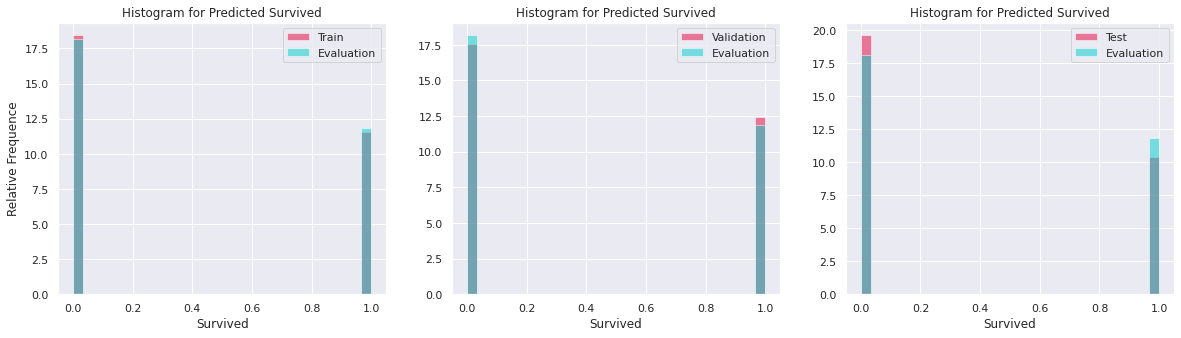

In [125]:
#  Load test data
df_evaluation = pd.read_csv("gender_submission.csv", sep=",")

# Make prediction over evaluation data
# predicted_prob_eva = stack_gen_model.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
df_evaluation.iloc[:,1] = eva_pred

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 3)
plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.show()

# Export file to submit in competition
df_evaluation.to_csv(submissions_path + '/Titanic_VOTING_XGBoost_Jimenez_v1.csv', index = False)

# Stack each model for ensemble method
# curr_mod = 'ens_xgb'
# df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
# df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
# df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
# df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
# df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
# df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
# df_eva_ens = pd.concat([df_eva_ens, df_evaluation.Survived], axis=1)
# df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Sklearn voting ensemble

In [138]:
from sklearn.ensemble import VotingClassifier
votingC = VotingClassifier(estimators=[#('ridge', ridge_grid.best_estimator_,), 
                                       ('lasso', lasso_grid.best_estimator_), ('svm', svm_grid), ('gb',gb_grid),('xgb',xgb_grid),('lgbm',lgbm_grid.best_estimator_)
                                ,('rf',rf_grid),('catb',cat_model_f),('ann',ann_grid),('dt',dt_grid)
                           ,('ens_xgb',stack_gen_model_xgb),('ens_rf',stack_gen_model_rf)
                           ], voting='soft', n_jobs=1)
 
votingC.fit(x_train.values, y_train.values)


print("======================================================================================")
# # Predict values of regression with train
# ypred_train = ensemble_models_predict(x_train, best_w)
# # Predict values of regression with validation
# ypred_val = ensemble_models_predict(x_val, best_w)
# # Predict values of regression with test
# ypred_test = ensemble_models_predict(x_test, best_w)

# Predict values of regression with train
ypred_train = votingC.predict(x_train.values)

# Predict values of regression with validation
ypred_val = votingC.predict(x_val.values)

# Predict values of regression with test
ypred_test = votingC.predict(x_test.values)

print("Evaluating results of the classification:")
print("Accuracy Score for train, validation, test: {}, {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val), accuracy_score(y_test, ypred_test)))
print("Precision Score for train, validation, test: {}, {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val), precision_score(y_test, ypred_test)))
print("Recall Score for train, validation, test: {}, {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val), recall_score(y_test, ypred_test)))
print("F1 Score for train, validation, test: {}, {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val), f1_score(y_test, ypred_test)))
# print("AUROC for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val), roc_auc_score(y_test, predicted_prob_test)))
# print("GINI for train, validation, test: {}, {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1, roc_auc_score(y_test, predicted_prob_test) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(votingC, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)


print("Ejecución: %s seconds" % (time.time() - start_time))

# x_test = df_data_OH[df_data_OH.Survived.isnull() == True].drop('Survived',axis=1)
# predictions_survived = votingC.predict(x_test)

0:	learn: 0.8014981	total: 17.5ms	remaining: 8.72s
1:	learn: 0.8108614	total: 21.1ms	remaining: 5.26s
2:	learn: 0.8146067	total: 31.2ms	remaining: 5.16s
3:	learn: 0.8127341	total: 42.1ms	remaining: 5.21s
4:	learn: 0.8127341	total: 48.2ms	remaining: 4.77s
5:	learn: 0.8127341	total: 52.2ms	remaining: 4.29s
6:	learn: 0.8108614	total: 54.5ms	remaining: 3.83s
7:	learn: 0.8127341	total: 58.5ms	remaining: 3.6s
8:	learn: 0.8220974	total: 62.9ms	remaining: 3.43s
9:	learn: 0.8183521	total: 66.2ms	remaining: 3.24s
10:	learn: 0.8220974	total: 71.1ms	remaining: 3.16s
11:	learn: 0.8220974	total: 74.5ms	remaining: 3.03s
12:	learn: 0.8220974	total: 78.1ms	remaining: 2.93s
13:	learn: 0.8220974	total: 82.8ms	remaining: 2.87s
14:	learn: 0.8220974	total: 91ms	remaining: 2.94s
15:	learn: 0.8202247	total: 94.9ms	remaining: 2.87s
16:	learn: 0.8220974	total: 98.3ms	remaining: 2.79s
17:	learn: 0.8202247	total: 102ms	remaining: 2.74s
18:	learn: 0.8220974	total: 106ms	remaining: 2.67s
19:	learn: 0.8220974	total:

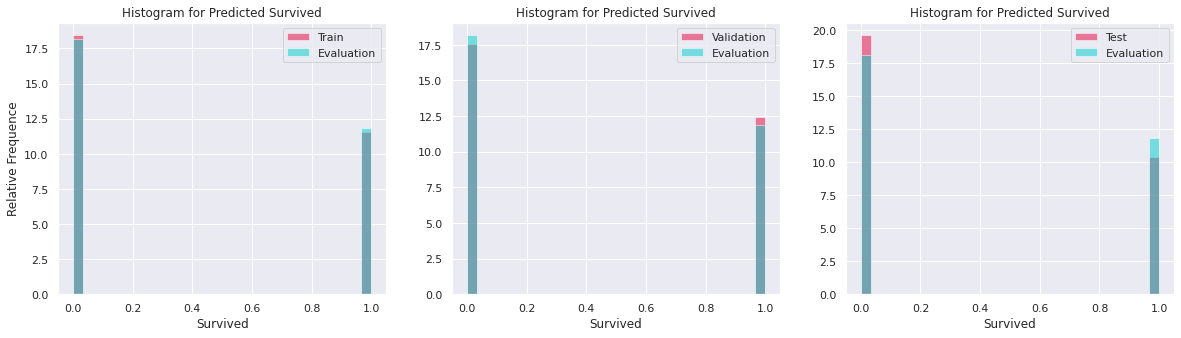

In [140]:
#  Load test data
df_evaluation = pd.read_csv("gender_submission.csv", sep=",")

# Make prediction over evaluation data
# predicted_prob_eva = votingC.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
df_evaluation.iloc[:,1] = votingC.predict(X_sub.values)

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.subplot(1, 3, 3)
plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
plt.hist(df_evaluation.Survived,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Survived')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Survived')
plt.show()

# Export file to submit in competition
df_evaluation.to_csv(submissions_path + '/Titanic_VOTING_method_Jimenez_v4.csv', index = False)

# Stack each model for ensemble method
# curr_mod = 'ens_xgb'
# df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
# df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
# df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
# df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
# df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
# df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
# df_eva_ens = pd.concat([df_eva_ens, df_evaluation.Survived], axis=1)
# df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# References

- https://www.kaggle.com/syalabiseet/xgboost-titanic-top-2-accuracy-98-8
- https://www.kaggle.com/javigallego/top-5-hyperparameter-tuning-ensemble-modeling